# mode OFFLINE + FakeInstrument

In [5]:
OFFLINE = True  # False au labo
rm = None       # évite "rm not defined" en offline

# =========================
# PARAMS OFFLINE (tu changes ICI)
# =========================
OFFLINE_GAIN   = 2.0        # gain BF (ex: non-inverseur = 2)
OFFLINE_FC_HZ  = 50_000.0   # fréquence de coupure (-3 dB) simulée
OFFLINE_SR_VUS = 0.50       # slew rate simulé (V/us) ~ LM741 typique

# =========================
# Fake Generator (mémorise la config envoyée)
# =========================
class FakeGen:
    def __init__(self, name="GEN"):
        self.name = name
        self.timeout = 10000
        self.read_termination = "\n"
        self.write_termination = "\n"
        self.chunk_size = 102400

        # état CH1 (on simule uniquement CH1)
        self.ch1_on = False
        self.wave = "SIN"      # SIN / SQU / RAMP
        self.freq_hz = 1000.0
        self.vpp = 1.0
        self.offset = 0.0
        self.phase = 0.0

    def clear(self): pass
    def close(self): pass

    def write(self, cmd: str):
        print(f"[{self.name} WRITE] {cmd}")
        c = cmd.strip().upper()

        # ON/OFF CH1
        if c in ("OUTP ON", "OUT ON", "OUTP1 ON"):
            self.ch1_on = True
            return
        if c in ("OUTP OFF", "OUT OFF", "OUTP1 OFF"):
            self.ch1_on = False
            return

        # Phase
        if c.startswith("PHAS "):
            try:
                self.phase = float(c.split()[1])
            except:
                pass
            return

        # APPL:<WAVE> f,vpp,offs  (CH1)
        if c.startswith("APPL:"):
            # ex: APPL:SIN 1000,1.0,0.0
            try:
                left, right = c.split(" ", 1)
                self.wave = left.split(":")[1]  # SIN / SQU / RAMP
                parts = [p.strip() for p in right.split(",")]
                self.freq_hz = float(parts[0])
                self.vpp = float(parts[1])
                self.offset = float(parts[2]) if len(parts) > 2 else 0.0
            except:
                pass
            return

    def query(self, cmd: str):
        print(f"[{self.name} QUERY] {cmd}")
        c = cmd.strip().upper()
        if c in ("OUTP?", "OUT?", "OUTP1?"):
            return "ON" if self.ch1_on else "OFF"
        if "FREQ" in c:
            return str(self.freq_hz)
        if "VPP" in c:
            return str(self.vpp)
        return "0"


# =========================
# Fake Scope (waveform dépend de GEN + fc + SR)
# =========================
class FakeScope:
    def __init__(self, gen: FakeGen, name="SCOPE"):
        self.name = name
        self.gen = gen

        self.timeout = 10000
        self.read_termination = "\n"
        self.write_termination = "\n"
        self.chunk_size = 102400

        self.wav_source = "CHAN1"  # CHAN1 ou CHAN2

        # waveform preamble
        self.N = 1200
        self.xincr = 1e-6
        self.xorig = 0.0
        self.xref  = 0.0
        self.yincr = 0.02
        self.yorig = 0.0
        self.yref  = 127.0

    def clear(self): pass
    def close(self): pass

    def write(self, cmd: str):
        print(f"[{self.name} WRITE] {cmd}")
        c = cmd.strip().upper()
        if c.startswith(":WAV:SOUR"):
            # :WAV:SOUR CHAN1
            self.wav_source = c.split()[-1]
        # le reste on ignore (MODE, FORM, TIM, TRIG...)

    def query(self, cmd: str):
        print(f"[{self.name} QUERY] {cmd}")
        c = cmd.strip().upper()

        # PREAMBLE demandé par read_waveform()
        if "WAV:PRE?" in c:
            # FORMAT,TYPE,POINTS,COUNT,XINCR,XORIG,XREF,YINCR,YORIG,YREF
            return f"0,0,{self.N},1,{self.xincr},{self.xorig},{self.xref},{self.yincr},{self.yorig},{self.yref}"

        # MEAS:ITEM? (3A)
        if ":MEAS:ITEM?" in c:
            # on renvoie des valeurs "cohérentes" basées sur waveform
            # mais 3A est optionnel; ici simple
            if "FREQ" in c:
                return str(self.gen.freq_hz)
            if "VPP" in c:
                # CHAN1 = Vin, CHAN2 = Vout
                vin = self.gen.vpp if self.gen.ch1_on else 0.0
                if "CHAN2" in c:
                    return str(self._vout_vpp(vin))
                return str(vin)
            if "VRMS" in c:
                return "0.353"
            if "VAVG" in c:
                return str(self.gen.offset)
            if "RTIM" in c:
                return "10e-6"
            return "0"

        return "0"

    def _vout_vpp(self, vin_vpp: float) -> float:
        """Bode 1er ordre: |H(f)| = G / sqrt(1+(f/fc)^2)"""
        f = max(1e-9, self.gen.freq_hz)
        G = OFFLINE_GAIN
        fc = OFFLINE_FC_HZ
        mag = G / np.sqrt(1.0 + (f / fc) ** 2)
        return vin_vpp * mag

    def read_raw(self):
        import numpy as np

        # temps
        t = np.arange(self.N) * self.xincr

        # entrée générateur (Vin)
        if not self.gen.ch1_on:
            vin = np.zeros_like(t)
        else:
            A = (self.gen.vpp / 2.0)
            f = self.gen.freq_hz
            w = self.gen.wave.upper()

            if w == "SIN":
                vin = A * np.sin(2*np.pi*f*t)
            elif w == "SQU":
                vin = A * np.sign(np.sin(2*np.pi*f*t))
            elif w in ("RAMP", "TRI"):
                # triangle
                vin = A * (2/np.pi) * np.arcsin(np.sin(2*np.pi*f*t))
            else:
                vin = A * np.sin(2*np.pi*f*t)

            vin = vin + self.gen.offset

        # sortie (Vout) = Vin * gain(f) + limitation SR (si square/triangle)
        if self.wav_source == "CHAN1":
            v = vin
        else:
            vin_vpp = self.gen.vpp if self.gen.ch1_on else 0.0
            vout_vpp = self._vout_vpp(vin_vpp)
            Aout = vout_vpp / 2.0

            # signal "idéal" (même forme que vin, juste amplitude)
            f = max(1e-9, self.gen.freq_hz)
            w = self.gen.wave.upper()

            if w == "SIN":
                v_ideal = Aout * np.sin(2*np.pi*f*t)
            elif w == "SQU":
                v_ideal = Aout * np.sign(np.sin(2*np.pi*f*t))
            elif w in ("RAMP", "TRI"):
                v_ideal = Aout * (2/np.pi) * np.arcsin(np.sin(2*np.pi*f*t))
            else:
                v_ideal = Aout * np.sin(2*np.pi*f*t)

            # Slew-rate limit: dv max = SR * dt
            sr_vs = OFFLINE_SR_VUS * 1e6  # V/s
            v = np.zeros_like(v_ideal)
            v[0] = v_ideal[0]
            for i in range(1, len(v)):
                dv = v_ideal[i] - v[i-1]
                dv_max = sr_vs * self.xincr
                dv = np.clip(dv, -dv_max, dv_max)
                v[i] = v[i-1] + dv

        # convertir V -> BYTE (inverse scaling)
        y = np.round((v - self.yorig) / self.yincr + self.yref).astype(np.int32)
        y = np.clip(y, 0, 255).astype(np.uint8).tobytes()

        header = f"#{len(str(len(y)))}{len(y)}".encode()
        return header + y


# =========================
# Factory OFFLINE
# =========================
if OFFLINE:
    gen = FakeGen("GEN")
    scope = FakeScope(gen, "SCOPE")


## Bloc 1 : detection des instruments 

Dans un premier temps, je détecte uniquement les ressources VISA pour identifier les instruments connectés, sans les ouvrir.

In [6]:
import pyvisa

rm = pyvisa.ResourceManager()
resources = rm.list_resources()

print("=== RESSOURCES VISA DETECTEES ===")
for i, r in enumerate(resources):
    print(f"[{i}] {r}")

print("\nNOTE:")
print("- USB0::... = instruments USBTMC (Rigol en USB normalement)")
print("- ASRLx::INSTR = ports série (COM). Ne choisis ça que si tu utilises un câble série/RS232.\n")

idx_gen = int(input("Index du GENERATEUR (ou -1 si pas présent): "))
idx_scope = int(input("Index de l'OSCILLO (ou -1 si pas présent): "))

GEN_ID = resources[idx_gen] if idx_gen >= 0 else None
SCOPE_ID = resources[idx_scope] if idx_scope >= 0 else None

# Avertissement si ASRL sélectionné
if GEN_ID and GEN_ID.startswith("ASRL"):
    print("\n⚠ ATTENTION: GEN_ID est un port série (ASRL).")
    print("   Si ton générateur est en USB, VISA ne le voit pas -> tu auras besoin de l'ID USB0::...")

if SCOPE_ID and SCOPE_ID.startswith("ASRL"):
    print("\n⚠ ATTENTION: SCOPE_ID est un port série (ASRL).")
    print("   Si ton oscillo est en USB, VISA ne le voit pas -> tu auras besoin de l'ID USB0::...")

print("\n=== IDS CHOISIS ===")
print("GEN_ID   =", GEN_ID)
print("SCOPE_ID =", SCOPE_ID)

rm.close()


=== RESSOURCES VISA DETECTEES ===
[0] ASRL7::INSTR
[1] ASRL8::INSTR

NOTE:
- USB0::... = instruments USBTMC (Rigol en USB normalement)
- ASRLx::INSTR = ports série (COM). Ne choisis ça que si tu utilises un câble série/RS232.


⚠ ATTENTION: GEN_ID est un port série (ASRL).
   Si ton générateur est en USB, VISA ne le voit pas -> tu auras besoin de l'ID USB0::...

⚠ ATTENTION: SCOPE_ID est un port série (ASRL).
   Si ton oscillo est en USB, VISA ne le voit pas -> tu auras besoin de l'ID USB0::...

=== IDS CHOISIS ===
GEN_ID   = ASRL7::INSTR
SCOPE_ID = ASRL8::INSTR


# Bloc 2 : Générateur (tu l’as déjà, je te donne juste les “defs” propres)

Tout d'abord : 
- si je veux un signal sinus 1 kHz, 1 Vpp, offset 0 au CH1 je decommente cette ligne : 
    - ch1_sine(1000, 1.0, 0.0, 0)
- Pour Tester le le slew rate (carré 10 kHz, 3 Vpp) :
    - ch1_square(10000, 3.0, 0.0, 0)
- Pour un sweep 100hz - 10KHz 
    - ch1_linear_sweep_sine(100, 10000, 1.0)


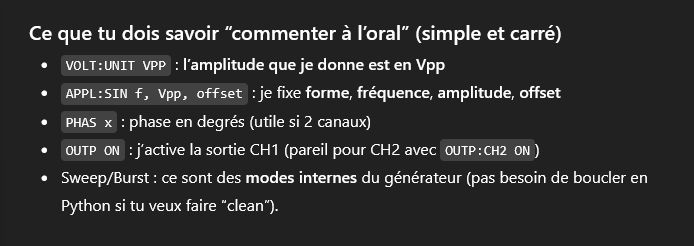

In [7]:
import pyvisa
import time


# MODE OFFLINE
# True  = pas au labo (FakeInstrument)
# False = au labo (vrai Rigol)
OFFLINE = True   #  mets False au labo


# ID MANUEL (collé depuis le Bloc 1)
GEN_ID = "USB0::0x0400::0x09C4::DG1F143800623::INSTR"


# FakeInstrument (pour OFFLINE)
class FakeInstrument:
    def __init__(self, name="FAKE"):
        self.name = name
        self.timeout = 10000
        self.read_termination = "\n"
        self.write_termination = "\n"
        self.chunk_size = 102400

    def clear(self): pass
    def close(self): pass

    def write(self, cmd):
        print(f"[{self.name} WRITE] {cmd}")

    def query(self, cmd):
        print(f"[{self.name} QUERY] {cmd}")
        return "0"


# Ouverture du générateur
if OFFLINE:
    rm = None
    gen = FakeInstrument("GEN")
    print("OFFLINE: Fake generator prêt.")
else:
    rm = pyvisa.ResourceManager()
    try:
        gen = rm.open_resource(GEN_ID)
        gen.timeout = 10000
        gen.read_termination = "\n"
        gen.write_termination = "\n"
        gen.chunk_size = 102400
        gen.clear()
        print("OK: Générateur ouvert ->", GEN_ID)
    except Exception as e:
        print("Impossible d'ouvrir le générateur:", GEN_ID)
        print("Erreur:", e)
        gen = None


# Helper write sécurisé
def gwrite(cmd: str, pause: float = 0.05):
    if gen is None:
        raise RuntimeError("Générateur non ouvert (gen=None)")
    gen.write(cmd)
    time.sleep(pause)


# ON / OFF canaux
def ch1_on():  
    gwrite("OUTP ON")
    print("CH1: ON")

def ch1_off(): 
    gwrite("OUTP OFF")
    print("CH1: OFF")

def ch2_on():  
    gwrite("OUTP:CH2 ON")
    print("CH2: ON")

def ch2_off(): 
    gwrite("OUTP:CH2 OFF")
    print("CH2: OFF")

def all_off():
    ch1_off()
    # ch2_off()  # optionnel


# Fonctions de base CH1 (APPL + PHAS + OUTP)
def ch1_sine(freq_hz, vpp, offset_v=0.0, phase_deg=0.0):
    gwrite("VOLT:UNIT VPP")
    gwrite(f"APPL:SIN {float(freq_hz)},{float(vpp)},{float(offset_v)}")
    gwrite(f"PHAS {float(phase_deg)}")
    ch1_on()

def ch1_square(freq_hz, vpp, offset_v=0.0, phase_deg=0.0):
    gwrite("VOLT:UNIT VPP")
    gwrite(f"APPL:SQU {float(freq_hz)},{float(vpp)},{float(offset_v)}")
    gwrite(f"PHAS {float(phase_deg)}")
    ch1_on()

def ch1_ramp(freq_hz, vpp, offset_v=0.0, phase_deg=0.0):
    gwrite("VOLT:UNIT VPP")
    gwrite(f"APPL:RAMP {float(freq_hz)},{float(vpp)},{float(offset_v)}")
    gwrite(f"PHAS {float(phase_deg)}")
    ch1_on()


# CH2 (Dual Channel – optionnel)
def ch2_ramp(freq_hz, vpp, offset_v=0.0, phase_deg=0.0):
    gwrite("VOLT:UNIT:CH2 VPP")
    gwrite(f"APPL:RAMP:CH2 {float(freq_hz)},{float(vpp)},{float(offset_v)}")
    gwrite(f"PHAS:CH2 {float(phase_deg)}")
    ch2_on()


# Sweep linéaire (Example 5 – Rigol)
def ch1_linear_sweep_sine(f_start, f_stop, sweep_time_s=1.0):
    gwrite("FUNC SIN")
    gwrite("SWE:STAT ON")
    gwrite("SWE:SPAC LIN")
    gwrite(f"FREQ:STAR {float(f_start)}")
    gwrite(f"FREQ:STOP {float(f_stop)}")
    gwrite(f"SWE:TIME {float(sweep_time_s)}")
    gwrite("TRIG:SOUR IMM")
    ch1_on()

def ch1_sweep_off():
    gwrite("SWE:STAT OFF")


# Burst (Example 6 – Rigol)
def ch1_burst_square(ncycles=3, burst_period_s=0.01, phase_deg=0.0):
    gwrite("FUNC SQU")
    gwrite("BURS:STAT ON")
    gwrite("BURS:MODE TRIG")
    gwrite(f"BURS:NCYC {int(ncycles)}")
    gwrite(f"BURS:PHAS {float(phase_deg)}")
    gwrite(f"BURS:INT:PER {float(burst_period_s)}")
    gwrite("TRIG:SOUR IMM")
    ch1_on()

def ch1_burst_off():
    gwrite("BURS:STAT OFF")


# EXEMPLES PRÊTS (décommenter à l’exam)

# Exemple 1 (doc Rigol)
# ch1_sine(20000, 2.5, 0.5, 10)

# Exemple simple labo
# ch1_sine(1000, 1.0, 0.0, 0)

# Rampe
# ch1_ramp(1000, 1.0)

# Dual channel
# ch1_sine(1000, 2.5, 0.5, 10)
# ch2_ramp(1500, 5.0, 0.5, 20)
# gwrite("PHAS:ALIGN")

# Sweep
# ch1_linear_sweep_sine(100, 10000, 1.0)

# Burst
# ch1_burst_square(ncycles=3, burst_period_s=0.01)

print("Bloc 2 prêt : décommente un exemple pour générer un signal.")


OFFLINE: Fake generator prêt.
Bloc 2 prêt : décommente un exemple pour générer un signal.


# Bloc3A : Oscillo Rigol : ouverture + mesures (MEAS) uniquement

Hypothèses :

- tu as déjà rm (si tu veux, sinon on le recrée)

- tu colles SCOPE_ID manuellement

- CH1 = input, CH2 = output


In [8]:
import time
import numpy as np
import pyvisa


#  MODE OFFLINE
# True  = pas au labo (FakeInstrument)
# False = au labo (vrai Rigol)
# (Doit être cohérent avec tes autres blocs)
# OFFLINE = True


# ID MANUEL OSCILLO
SCOPE_ID = "USB0::0x1AB1::0x04CE::DS1ZC212301111::INSTR"  # <-- colle ton ID ici


# Ouverture oscillo (OFFLINE / ONLINE)
if OFFLINE:
    scope = FakeInstrument("SCOPE")
    print("OFFLINE: Fake oscilloscope prêt.")
else:
    # Si rm n'existe pas (notebook lancé direct), on le crée
    if "rm" not in globals() or rm is None:
        rm = pyvisa.ResourceManager()

    try:
        scope = rm.open_resource(SCOPE_ID)
        scope.timeout = 10000
        scope.read_termination  = "\n"
        scope.write_termination = "\n"
        scope.chunk_size = 102400
        scope.clear()
        print("OK: Oscillo ouvert ->", SCOPE_ID)
    except Exception as e:
        print(" Impossible d'ouvrir l'oscilloscope:", SCOPE_ID)
        print("Erreur:", e)
        scope = None


# Helpers sécurisés
def swrite(cmd: str, pause: float = 0.05):
    if scope is None:
        raise RuntimeError("Oscilloscope non ouvert (scope=None)")
    scope.write(cmd)
    time.sleep(pause)

def squery(cmd: str) -> str:
    if scope is None:
        raise RuntimeError("Oscilloscope non ouvert (scope=None)")
    return scope.query(cmd)

def autoscale():
    """
    Autoscale complet (utile si les mesures retournent 9.9e37 / NaN).
    Laisse commenté si tu préfères tout régler à la main.
    """
    swrite(":AUT")
    time.sleep(4)


# Config minimale (optionnelle, commentable)
if scope is not None:
    swrite(":CHAN1:DISP ON")
    swrite(":CHAN2:DISP ON")
    swrite(":CHAN1:COUP DC")
    swrite(":CHAN2:COUP DC")

    # IMPORTANT: mets 1 ou 10 selon la sonde PHYSIQUE (commutateur sur la sonde)
    # swrite(":CHAN1:PROB 1")
    # swrite(":CHAN2:PROB 1")

    # Trigger stable (optionnel)
    swrite(":TRIG:MODE EDGE")
    swrite(":TRIG:EDG:SOUR CHAN1")
    swrite(":TRIG:EDG:LEV 0")
    swrite(":RUN")

    # Si besoin au labo:
    # autoscale()

# Lecture des mesures via :MEAS:ITEM?
def meas(item: str, ch: int) -> float:
    """
    Items utiles (souvent supportés) :
      - VPP   : tension crête-à-crête
      - VRMS  : RMS
      - FREQ  : fréquence
      - VAVG  : moyenne (offset approx)
      - RTIM  : rise time (temps de montée)
    """
    try:
        s = squery(f":MEAS:ITEM? {item},CHAN{ch}").strip()
        val = float(s)

        # Valeur invalide typique Rigol (ex: 9.9e37)
        if val > 1e30:
            return float("nan")
        return val
    except Exception:
        return float("nan")

def read_channel(ch: int):
    return {
        "Vpp":   meas("VPP",  ch),
        "Vrms":  meas("VRMS", ch),
        "Freq":  meas("FREQ", ch),
        "Vmean": meas("VAVG", ch),   # moyenne -> offset approx
        "Rise":  meas("RTIM", ch),   # temps de montée (utile surtout CH2 pour slew rate)
    }


# Exemple de lecture instantanée
ch1 = read_channel(1)  # input
ch2 = read_channel(2)  # output

print("\n=== CH1 (INPUT) ===")
for k, v in ch1.items():
    print(f"{k:>6} = {v}")

print("\n=== CH2 (OUTPUT) ===")
for k, v in ch2.items():
    print(f"{k:>6} = {v}")


OFFLINE: Fake oscilloscope prêt.
[SCOPE WRITE] :CHAN1:DISP ON
[SCOPE WRITE] :CHAN2:DISP ON
[SCOPE WRITE] :CHAN1:COUP DC
[SCOPE WRITE] :CHAN2:COUP DC
[SCOPE WRITE] :TRIG:MODE EDGE
[SCOPE WRITE] :TRIG:EDG:SOUR CHAN1
[SCOPE WRITE] :TRIG:EDG:LEV 0
[SCOPE WRITE] :RUN
[SCOPE QUERY] :MEAS:ITEM? VPP,CHAN1
[SCOPE QUERY] :MEAS:ITEM? VRMS,CHAN1
[SCOPE QUERY] :MEAS:ITEM? FREQ,CHAN1
[SCOPE QUERY] :MEAS:ITEM? VAVG,CHAN1
[SCOPE QUERY] :MEAS:ITEM? RTIM,CHAN1
[SCOPE QUERY] :MEAS:ITEM? VPP,CHAN2
[SCOPE QUERY] :MEAS:ITEM? VRMS,CHAN2
[SCOPE QUERY] :MEAS:ITEM? FREQ,CHAN2
[SCOPE QUERY] :MEAS:ITEM? VAVG,CHAN2
[SCOPE QUERY] :MEAS:ITEM? RTIM,CHAN2

=== CH1 (INPUT) ===
   Vpp = 0.0
  Vrms = 0.0
  Freq = 0.0
 Vmean = 0.0
  Rise = 0.0

=== CH2 (OUTPUT) ===
   Vpp = 0.0
  Vrms = 0.0
  Freq = 0.0
 Vmean = 0.0
  Rise = 0.0


# Bloc3B : Oscillo Rigol : waveform + plot + mesures calculées

[SCOPE WRITE] :WAV:SOUR CHAN1
[SCOPE WRITE] :WAV:MODE NORM
[SCOPE WRITE] :WAV:FORM BYTE
[SCOPE QUERY] :WAV:PRE?
[SCOPE WRITE] :WAV:DATA?
[SCOPE WRITE] :WAV:SOUR CHAN2
[SCOPE WRITE] :WAV:MODE NORM
[SCOPE WRITE] :WAV:FORM BYTE
[SCOPE QUERY] :WAV:PRE?
[SCOPE WRITE] :WAV:DATA?

=== CH1 (INPUT) - metrics (waveform) ===
        Vmin = -1.0
        Vmax = 1.0
         Vpp = 2.0
       Vmean = -0.009866666666666682
        Vrms = 0.7068007734385505
 Freq_est_zc = 4166.666666666667
Freq_est_fft = nan
    Freq_est = 4166.666666666667

=== CH2 (OUTPUT) - metrics (waveform) ===
        Vmin = -1.0
        Vmax = 1.0
         Vpp = 2.0
       Vmean = -0.009866666666666682
        Vrms = 0.7068007734385505
 Freq_est_zc = 4166.666666666667
Freq_est_fft = nan
    Freq_est = 4166.666666666667

Gain (Vpp_out/Vpp_in) = 1.000
Slew rate estimé (CH2) = 0.04 V/us


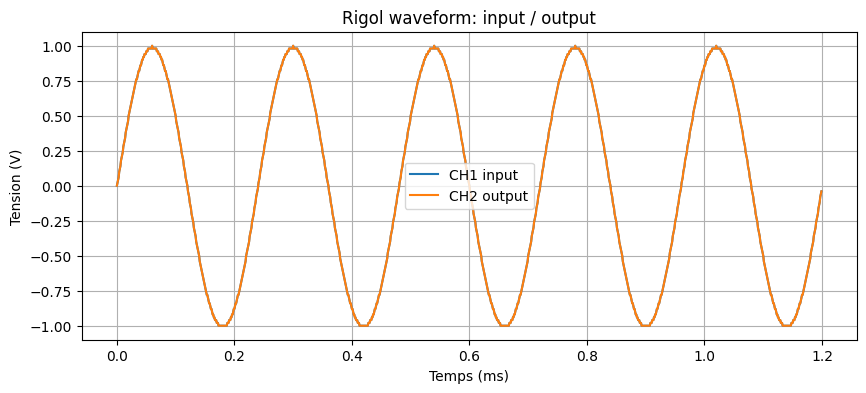

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import time

# ============================================================
# 0) Helpers IEEE488.2 : parse block binaire "#<n><len><data>"
# ============================================================
def _parse_ieee_block(raw: bytes) -> bytes:
    if not raw:
        return b""
    if raw[:1] != b"#":
        # Certains firmwares peuvent renvoyer ASCII, on garde brut
        return raw
    n = int(raw[1:2].decode(errors="ignore"))
    L = int(raw[2:2+n].decode(errors="ignore"))
    return raw[2+n:2+n+L]

def _swrite(cmd: str, pause: float = 0.02):
    if scope is None:
        raise RuntimeError("Oscilloscope non ouvert (scope=None)")
    scope.write(cmd)
    time.sleep(pause)

def _squery(cmd: str) -> str:
    if scope is None:
        raise RuntimeError("Oscilloscope non ouvert (scope=None)")
    return scope.query(cmd)

# ============================================================
# 1) Lire la waveform d’un canal (CHAN1 / CHAN2)
# ============================================================
def read_waveform(channel="CHAN1"):
    """
    Renvoie t (s) et v (V) depuis l’oscillo Rigol.
    - Utilise PREamble pour scaler correctement
    - WAV:FORM BYTE (robuste)
    - WAV:MODE NORM (points affichés)
    """
    _swrite(f":WAV:SOUR {channel}")
    _swrite(":WAV:MODE NORM")
    _swrite(":WAV:FORM BYTE")

    pre_str = _squery(":WAV:PRE?").strip()
    pre = pre_str.split(',')

    # En OFFLINE ou si firmware bizarre, PRE peut être invalide
    if len(pre) < 10:
        if OFFLINE:
            # FORMAT,TYPE,POINTS,COUNT,XINCR,XORIG,XREF,YINCR,YORIG,YREF
            pre = "0,0,1200,1,1e-6,0,0,0.02,0,127".split(',')
        else:
            raise RuntimeError(f"PREamble inattendue: '{pre_str}'")

    # PRE: FORMAT,TYPE,POINTS,COUNT,XINCR,XORIG,XREF,YINCR,YORIG,YREF
    points = int(float(pre[2]))
    xincr = float(pre[4])
    xorig = float(pre[5])
    xref  = float(pre[6])
    yincr = float(pre[7])
    yorig = float(pre[8])
    yref  = float(pre[9])

    # Lecture data
    scope.write(":WAV:DATA?")

    # OFFLINE safe: si FakeInstrument n'a pas read_raw, on fabrique une waveform
    if OFFLINE and not hasattr(scope, "read_raw"):
        N = points if points > 0 else 1200
        cycles = 5  # ✅ plusieurs périodes -> fréquence estimable
        y = (127 + 50*np.sin(2*np.pi*cycles*np.arange(N)/N)).astype(np.uint8).tobytes()
        header = f"#{len(str(len(y)))}{len(y)}".encode()
        raw = header + y
    else:
        raw = scope.read_raw()

    data = _parse_ieee_block(raw)

    # Convertit en uint8 (BYTE)
    y = np.frombuffer(data, dtype=np.uint8).astype(np.float64)

    # Ajustement taille
    if points > 0 and y.size >= points:
        y = y[:points]
    elif points > 0 and y.size < points:
        points = y.size

    v = (y - yref) * yincr + yorig

    i = np.arange(v.size, dtype=np.float64)
    t = (i - xref) * xincr + xorig
    return t, v

# ============================================================
# 2) Mesures calculées à partir des points
# ============================================================
def _freq_est_zero_cross(t, v, vmean, vpp):
    """Estimation fréquence robuste par passages de seuil (anti sign(0))."""
    if not np.isfinite(vpp) or vpp <= 0:
        return float("nan")

    vc = v - vmean
    thr = 0.02 * vpp  # 2% de Vpp
    if thr <= 0:
        return float("nan")

    state = np.zeros_like(vc, dtype=np.int8)
    state[vc >  thr] =  1
    state[vc < -thr] = -1

    nz = np.where(state != 0)[0]
    if nz.size <= 3:
        return float("nan")

    st = state[nz]
    tz = t[nz]
    cross = np.where(np.diff(st) != 0)[0]
    if cross.size < 2:
        return float("nan")

    tc = tz[cross]
    periods = tc[2:] - tc[:-2]  # 2 changements => ~1 période
    if periods.size == 0:
        return float("nan")

    T = float(np.mean(periods))
    return 1.0 / T if T > 0 else float("nan")

def _freq_est_fft(t, v, vmean):
    """Fallback FFT: prend le pic max (hors DC)."""
    if t.size < 8:
        return float("nan")

    dt = float(np.mean(np.diff(t)))
    if dt <= 0:
        return float("nan")

    x = v - vmean
    X = np.fft.rfft(x)
    f = np.fft.rfftfreq(x.size, d=dt)
    mag = np.abs(X)

    if mag.size <= 1:
        return float("nan")

    k = int(np.argmax(mag[1:]) + 1)  # ignore DC
    return float(f[k])

def compute_metrics(t, v):
    vmin = float(np.min(v))
    vmax = float(np.max(v))
    vpp  = vmax - vmin
    vmean = float(np.mean(v))
    vrms  = float(np.sqrt(np.mean(v**2)))

    # 1) Zero-cross robuste
    f_zc = _freq_est_zero_cross(t, v, vmean, vpp)

    # 2) Fallback FFT si ZC échoue
    f_fft = _freq_est_fft(t, v, vmean) if not np.isfinite(f_zc) else float("nan")

    # 3) Fréquence finale (priorité ZC, sinon FFT)
    freq = f_zc if np.isfinite(f_zc) else f_fft

    return {
        "Vmin": vmin,
        "Vmax": vmax,
        "Vpp": float(vpp),
        "Vmean": vmean,
        "Vrms": vrms,
        "Freq_est_zc": f_zc,
        "Freq_est_fft": f_fft,
        "Freq_est": freq
    }

def compute_slew_rate(t, v):
    """
    Slew rate approx = max(|dV/dt|) sur la trace
    Retour en V/us
    """
    dv = np.diff(v)
    dt = np.diff(t)
    good = dt > 0
    if not np.any(good):
        return float("nan")
    slope = np.max(np.abs(dv[good] / dt[good]))  # V/s
    return float(slope / 1e6)                     # V/us

# ============================================================
# 3) Lecture CH1/CH2 + affichage
# ============================================================
t1, v1 = read_waveform("CHAN1")  # input
t2, v2 = read_waveform("CHAN2")  # output

m1 = compute_metrics(t1, v1)
m2 = compute_metrics(t2, v2)

print("\n=== CH1 (INPUT) - metrics (waveform) ===")
for k, val in m1.items():
    print(f"{k:>12} = {val}")

print("\n=== CH2 (OUTPUT) - metrics (waveform) ===")
for k, val in m2.items():
    print(f"{k:>12} = {val}")

gain = (m2["Vpp"] / m1["Vpp"]) if m1["Vpp"] > 1e-9 else float("nan")
print(f"\nGain (Vpp_out/Vpp_in) = {gain:.3f}")

sr_out = compute_slew_rate(t2, v2)
print(f"Slew rate estimé (CH2) = {sr_out:.2f} V/us")

# ============================================================
# 4) Plot
# ============================================================
plt.figure(figsize=(10,4))
plt.plot(t1*1e3, v1, label="CH1 input")
plt.plot(t2*1e3, v2, label="CH2 output")
plt.xlabel("Temps (ms)")
plt.ylabel("Tension (V)")
plt.title("Rigol waveform: input / output")
plt.grid(True)
plt.legend()
plt.show()


# Bloc 3C : Sweep fréquence + fc(-3 dB) + Bode


=== SWEEP FREQUENCE ===
    Freq(Hz) |  Vin(Vpp) |  Vout(Vpp) |    Gain | Gain(dB)
--------------------------------------------------------------
[SCOPE WRITE] :WAV:SOUR CHAN1
[SCOPE WRITE] :WAV:MODE NORM
[SCOPE WRITE] :WAV:FORM BYTE
[SCOPE QUERY] :WAV:PRE?
[SCOPE WRITE] :WAV:DATA?
[SCOPE WRITE] :WAV:SOUR CHAN2
[SCOPE WRITE] :WAV:MODE NORM
[SCOPE WRITE] :WAV:FORM BYTE
[SCOPE QUERY] :WAV:PRE?
[SCOPE WRITE] :WAV:DATA?
       100.0 |     2.000 |      2.000 |   1.000 |     0.00
[SCOPE WRITE] :WAV:SOUR CHAN1
[SCOPE WRITE] :WAV:MODE NORM
[SCOPE WRITE] :WAV:FORM BYTE
[SCOPE QUERY] :WAV:PRE?
[SCOPE WRITE] :WAV:DATA?
[SCOPE WRITE] :WAV:SOUR CHAN2
[SCOPE WRITE] :WAV:MODE NORM
[SCOPE WRITE] :WAV:FORM BYTE
[SCOPE QUERY] :WAV:PRE?
[SCOPE WRITE] :WAV:DATA?
       184.8 |     2.000 |      2.000 |   1.000 |     0.00
[SCOPE WRITE] :WAV:SOUR CHAN1
[SCOPE WRITE] :WAV:MODE NORM
[SCOPE WRITE] :WAV:FORM BYTE
[SCOPE QUERY] :WAV:PRE?
[SCOPE WRITE] :WAV:DATA?
[SCOPE WRITE] :WAV:SOUR CHAN2
[SCOPE WRITE] :WAV:M

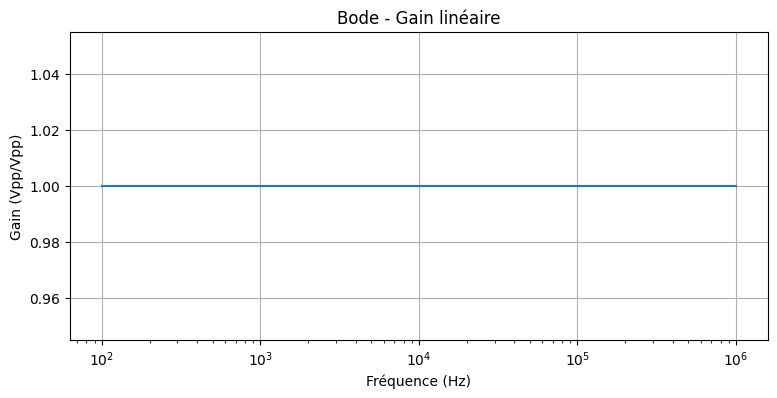

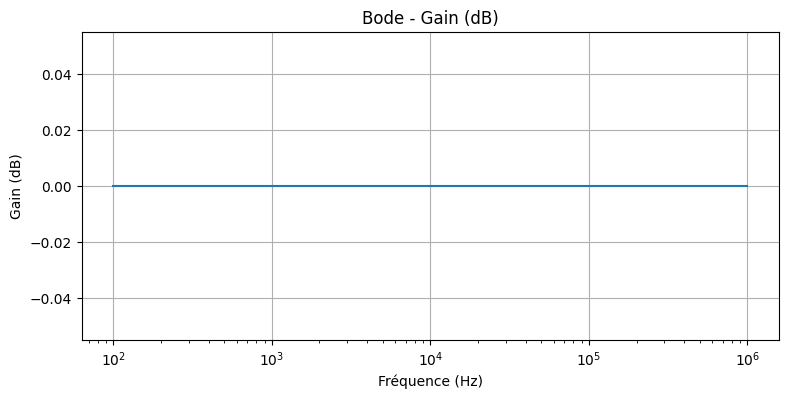

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import time

# ============================================================
# 1) Sweep : liste de fréquences (log)
# ============================================================
def make_log_freqs(f_start=100, f_stop=1e6, n=18):
    return np.logspace(np.log10(f_start), np.log10(f_stop), n)

# ============================================================
# 2) Mesure gain à une fréquence (via waveform)
#    - CH1 = input
#    - CH2 = output
# ============================================================
def measure_gain_waveform(freq_hz, vpp_in_cmd=1.0, settle=0.25, set_timebase=True):
    # ----- 2.1 Générateur : sinus sur CH1 -----
    # OFFLINE: on ne pilote pas le générateur
    if not OFFLINE:
        # Tu dois avoir ch1_sine(freq, vpp, offset, phase)
        ch1_sine(float(freq_hz), float(vpp_in_cmd), 0.0, 0.0)
        time.sleep(settle)

    # ----- 2.2 Oscillo : timebase pour voir ~2-3 périodes -----
    if (not OFFLINE) and set_timebase:
        T = 1.0 / float(freq_hz)
        # 10 divisions horizontales -> 2.5 périodes si SCAL = T/4
        _swrite(f":TIM:SCAL {T/4.0}")
        time.sleep(0.15)

    # ----- 2.3 Lecture waveform + metrics -----
    t1, v1 = read_waveform("CHAN1")
    t2, v2 = read_waveform("CHAN2")
    m1 = compute_metrics(t1, v1)
    m2 = compute_metrics(t2, v2)

    vin  = float(m1["Vpp"])
    vout = float(m2["Vpp"])
    gain = (vout / vin) if vin > 1e-9 else float("nan")
    gain_db = 20*np.log10(gain) if (np.isfinite(gain) and gain > 0) else float("nan")

    return {
        "f": float(freq_hz),
        "vin_vpp": vin,
        "vout_vpp": vout,
        "gain": gain,
        "gain_db": gain_db,
        "m1": m1,
        "m2": m2,
    }

# ============================================================
# 3) Sweep complet
# ============================================================
def run_sweep(freqs, vpp_in_cmd=1.0, settle=0.25, set_timebase=True):
    rows = []
    print("\n=== SWEEP FREQUENCE ===")
    print(f"{'Freq(Hz)':>12} | {'Vin(Vpp)':>9} | {'Vout(Vpp)':>10} | {'Gain':>7} | {'Gain(dB)':>8}")
    print("-"*62)

    for f in freqs:
        r = measure_gain_waveform(f, vpp_in_cmd=vpp_in_cmd, settle=settle, set_timebase=set_timebase)
        rows.append(r)
        print(f"{r['f']:12.1f} | {r['vin_vpp']:9.3f} | {r['vout_vpp']:10.3f} | {r['gain']:7.3f} | {r['gain_db']:8.2f}")

    return rows

# ============================================================
# 4) Trouver fc (-3 dB) par rapport au gain de référence (premier point valide)
#    + interpolation linéaire sur le gain (mieux qu'un simple seuil)
# ============================================================
def find_f3db(rows):
    # extrait points valides
    f = np.array([r["f"] for r in rows], dtype=float)
    g = np.array([r["gain"] for r in rows], dtype=float)

    mask = np.isfinite(g) & (g > 0)
    if not np.any(mask):
        return {"f3db": None, "g0": None, "target": None}

    f = f[mask]
    g = g[mask]

    # gain ref = premier point (le plus bas en fréquence normalement)
    g0 = float(g[0])
    target = 0.707 * g0

    # trouve intervalle où ça traverse target
    # on cherche le premier indice i tel que g[i] < target
    idx = np.where(g < target)[0]
    if idx.size == 0:
        return {"f3db": None, "g0": g0, "target": target}

    i = int(idx[0])
    if i == 0:
        return {"f3db": float(f[0]), "g0": g0, "target": target}

    # interpolation sur (f[i-1], g[i-1]) -> (f[i], g[i])
    f1, g1 = float(f[i-1]), float(g[i-1])
    f2, g2 = float(f[i]),   float(g[i])

    # évite division par 0
    if g2 == g1:
        f3db = f2
    else:
        # interpolation linéaire en gain (OK pour une estimation)
        alpha = (target - g1) / (g2 - g1)
        f3db = f1 + alpha * (f2 - f1)

    return {"f3db": float(f3db), "g0": g0, "target": target}

# ============================================================
# 5) Plot Bode (gain et gain dB)
# ============================================================
def plot_bode(rows, info=None):
    freqs = np.array([r["f"] for r in rows], dtype=float)
    gains = np.array([r["gain"] for r in rows], dtype=float)
    gains_db = np.array([r["gain_db"] for r in rows], dtype=float)

    plt.figure(figsize=(9,4))
    plt.semilogx(freqs, gains)
    plt.xlabel("Fréquence (Hz)")
    plt.ylabel("Gain (Vpp/Vpp)")
    plt.grid(True)
    plt.title("Bode - Gain linéaire")
    if info and info["f3db"] is not None:
        plt.axvline(info["f3db"])
    plt.show()

    plt.figure(figsize=(9,4))
    plt.semilogx(freqs, gains_db)
    plt.xlabel("Fréquence (Hz)")
    plt.ylabel("Gain (dB)")
    plt.grid(True)
    plt.title("Bode - Gain (dB)")
    if info and info["f3db"] is not None:
        plt.axvline(info["f3db"])
    plt.show()

# ============================================================
# 6) RUN (tu ajustes la plage)
# ============================================================
freqs = make_log_freqs(100, 1e6, 16)      # 100 Hz -> 1 MHz

rows = run_sweep(freqs, vpp_in_cmd=1.0, settle=0.25, set_timebase=True)

info = find_f3db(rows)
print("\n=== RESULTAT -3 dB ===")
print("Gain ref (g0) =", info["g0"])
print("Seuil -3 dB   =", info["target"])
print("f3dB          =", info["f3db"])

plot_bode(rows, info)


# Bloc 3 D : Mesure Slew Rate (max dV/dt) + zoom front

[GEN WRITE] VOLT:UNIT VPP
[GEN WRITE] APPL:SQU 10000.0,3.0,0.0
[GEN WRITE] PHAS 0.0
[GEN WRITE] OUTP ON
CH1: ON
[SCOPE WRITE] :TIM:SCAL 5e-6
[SCOPE WRITE] :TRIG:MODE EDGE
[SCOPE WRITE] :TRIG:EDG:SOUR CHAN2
[SCOPE WRITE] :TRIG:EDG:LEV 0
[SCOPE WRITE] :RUN
[SCOPE WRITE] :WAV:SOUR CHAN2
[SCOPE WRITE] :WAV:MODE NORM
[SCOPE WRITE] :WAV:FORM BYTE
[SCOPE QUERY] :WAV:PRE?
[SCOPE WRITE] :WAV:DATA?
Slew Rate mesuré = 0.04 V/µs


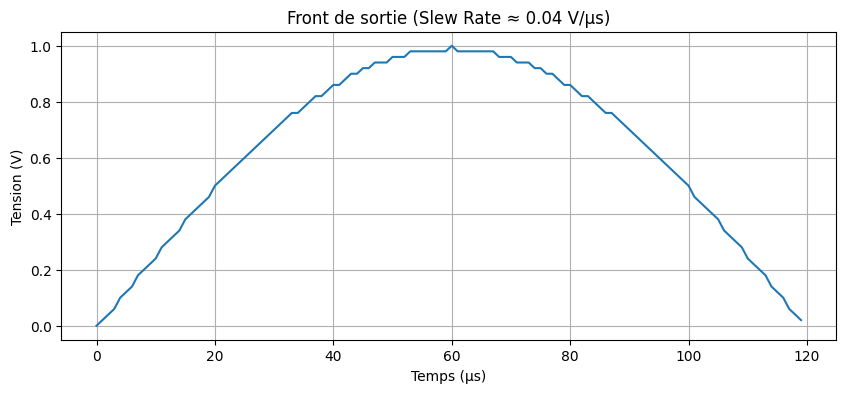

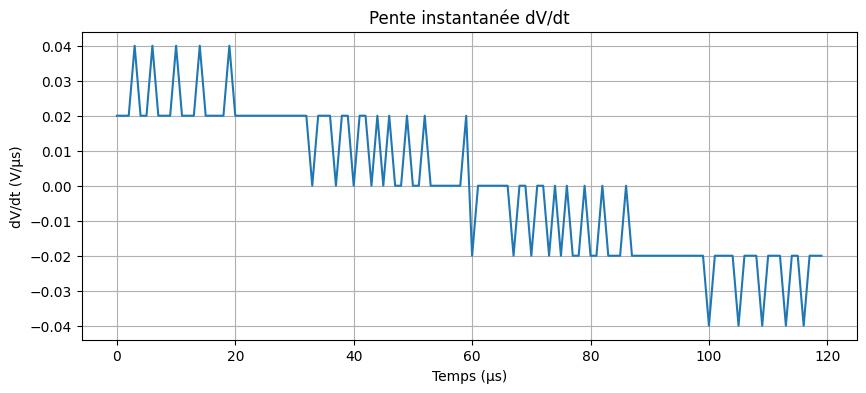

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import time

# ------------------------------------------------------------
# 1) Config signal pour SR (carré)
# ------------------------------------------------------------
def setup_for_slew_rate(freq_hz=10000, vpp=3.0, offset=0.0):
    """
    On envoie un carré: plus c’est grand, plus tu vois la limitation SR.
    Mais attention à ne pas saturer l’AOP (output swing).
    """
    ch1_square(freq_hz, vpp, offset, 0.0)
    time.sleep(0.3)

    # Timebase : zoom sur le front
    # LM741 ~0.5 V/us -> pour quelques volts ça fait ~10 us de montée
    _swrite(":TIM:SCAL 5e-6")  # 5 us/div
    time.sleep(0.2)

    # Trigger sur sortie (CH2) pour stabiliser le front
    _swrite(":TRIG:MODE EDGE")
    _swrite(":TRIG:EDG:SOUR CHAN2")
    _swrite(":TRIG:EDG:LEV 0")
    _swrite(":RUN")
    time.sleep(0.3)

# ------------------------------------------------------------
# 2) Slew Rate via waveform (max|dV/dt|)
# ------------------------------------------------------------
def slew_rate_from_waveform(channel="CHAN2"):
    t, v = read_waveform(channel)
    dv = np.diff(v)
    dt = np.diff(t)

    good = dt > 0
    dvdt = dv[good] / dt[good]       # V/s
    t_mid = t[:-1][good]             # temps associé

    sr_vs = np.max(np.abs(dvdt)) if dvdt.size else float("nan")
    sr_vus = sr_vs / 1e6

    return sr_vus, t, v, t_mid, dvdt


# ------------------------------------------------------------
# 3) Zoom sur un front (pour le plot)
# ------------------------------------------------------------
def plot_front_and_slope(t, v, t_dv, dvdt, sr_vus):
    vmean = np.mean(v)
    idx = np.argmin(np.abs(v - vmean))

    n = len(v)
    w = max(50, n // 10)
    i0 = max(0, idx - w)
    i1 = min(n, idx + w)

    # --- Plot V(t)
    plt.figure(figsize=(10,4))
    plt.plot((t[i0:i1] - t[idx]) * 1e6, v[i0:i1])
    plt.xlabel("Temps (µs)")
    plt.ylabel("Tension (V)")
    plt.title(f"Front de sortie (Slew Rate ≈ {sr_vus:.2f} V/µs)")
    plt.grid(True)
    plt.show()

    # --- Plot dV/dt
    plt.figure(figsize=(10,4))
    plt.plot((t_dv[i0:i1] - t[idx]) * 1e6, dvdt[i0:i1] / 1e6)
    plt.xlabel("Temps (µs)")
    plt.ylabel("dV/dt (V/µs)")
    plt.title("Pente instantanée dV/dt")
    plt.grid(True)
    plt.show()

# ------------------------------------------------------------
# 4) RUN SR
# ------------------------------------------------------------
setup_for_slew_rate(freq_hz=10000, vpp=3.0, offset=0.0)

sr_vus, t2, v2, t_dv, dvdt = slew_rate_from_waveform("CHAN2")

print(f"Slew Rate mesuré = {sr_vus:.2f} V/µs")

plot_front_and_slope(t2, v2, t_dv, dvdt, sr_vus)



# Bloc 4 : Slew Rate auto (anti-saturation) + sélection meilleure amplitude


=== AUTO SLEW RATE TEST ===
Signal: carré 10000 Hz | essais Vin Vpp = [0.5, 1.0, 2.0, 3.0, 4.0]

[GEN WRITE] VOLT:UNIT VPP
[GEN WRITE] APPL:SQU 10000.0,0.5,0.0
[GEN WRITE] PHAS 0.0
[GEN WRITE] OUTP ON
CH1: ON
[SCOPE WRITE] :TIM:SCAL 5e-6
[SCOPE WRITE] :TRIG:MODE EDGE
[SCOPE WRITE] :TRIG:EDG:SOUR CHAN2
[SCOPE WRITE] :TRIG:EDG:LEV 0
[SCOPE WRITE] :RUN
[SCOPE WRITE] :WAV:SOUR CHAN2
[SCOPE WRITE] :WAV:MODE NORM
[SCOPE WRITE] :WAV:FORM BYTE
[SCOPE QUERY] :WAV:PRE?
[SCOPE WRITE] :WAV:DATA?
Vin=0.50 Vpp -> SR=0.04 V/µs | clipped=False
[GEN WRITE] VOLT:UNIT VPP
[GEN WRITE] APPL:SQU 10000.0,1.0,0.0
[GEN WRITE] PHAS 0.0
[GEN WRITE] OUTP ON
CH1: ON
[SCOPE WRITE] :TIM:SCAL 5e-6
[SCOPE WRITE] :TRIG:MODE EDGE
[SCOPE WRITE] :TRIG:EDG:SOUR CHAN2
[SCOPE WRITE] :TRIG:EDG:LEV 0
[SCOPE WRITE] :RUN
[SCOPE WRITE] :WAV:SOUR CHAN2
[SCOPE WRITE] :WAV:MODE NORM
[SCOPE WRITE] :WAV:FORM BYTE
[SCOPE QUERY] :WAV:PRE?
[SCOPE WRITE] :WAV:DATA?
Vin=1.00 Vpp -> SR=0.04 V/µs | clipped=False
[GEN WRITE] VOLT:UNIT VPP
[G

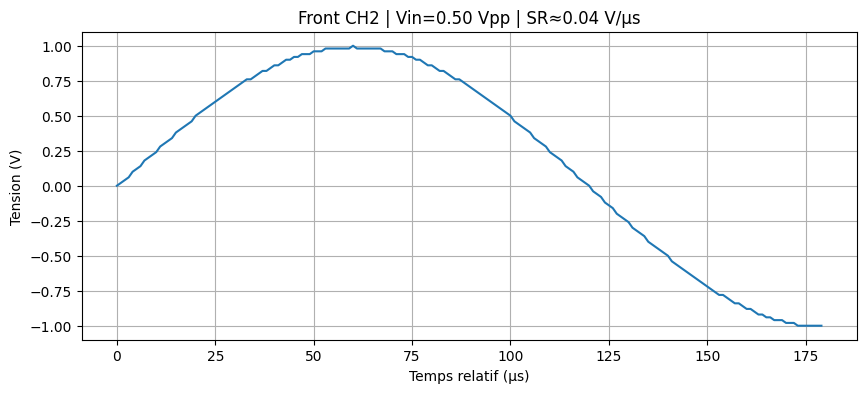

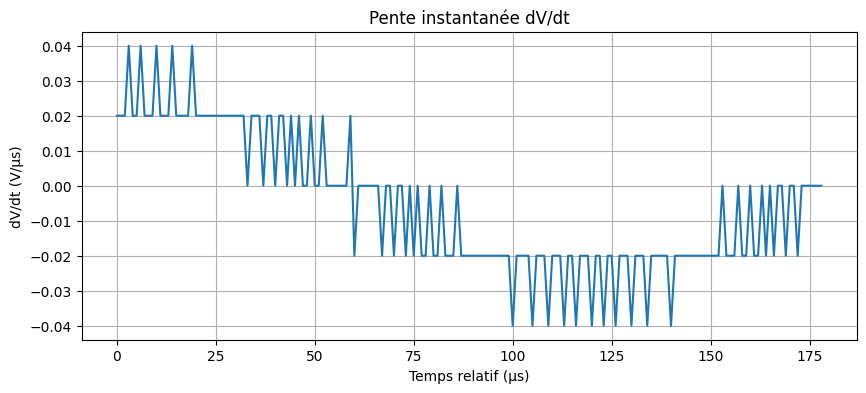


Result = {'SR_V_per_us': 0.04000000000000015, 'Vin_Vpp': 0.5}


In [12]:
import numpy as np
import matplotlib.pyplot as plt
import time

# ============================================================
# 1) Détection clipping / saturation (robuste)
# ============================================================
def is_clipped(v, t=None, frac_level=0.02, slope_thr_vus=0.002, frac_flat=0.25):
    """
    Détection clipping plus robuste :
    - cherche des zones proches du min/max où la pente |dV/dt| est quasi nulle
    - si une grosse fraction de points est "collée" ET "plate" -> clipping probable

    frac_level   : zone proche des extrêmes (2% de Vpp)
    slope_thr_vus: pente considérée 'plate' (V/µs)
    frac_flat    : seuil fraction de points plats aux extrêmes
    """
    vmin, vmax = float(np.min(v)), float(np.max(v))
    vpp = vmax - vmin
    if vpp <= 1e-6:
        return True

    eps = frac_level * vpp

    # si pas de t fourni, on suppose échantillonnage uniforme et on fait simple
    if t is None:
        dv = np.diff(v)
        flat = np.abs(dv) < (eps * 0.05)   # "presque constant"
        # points proches des extrêmes
        near_min = v[:-1] <= (vmin + eps)
        near_max = v[:-1] >= (vmax - eps)

        flat_min = np.mean(flat & near_min)
        flat_max = np.mean(flat & near_max)
        return (flat_min > frac_flat) or (flat_max > frac_flat)

    # version avec t -> pente réelle
    dv = np.diff(v)
    dt = np.diff(t)
    good = dt > 0
    if not np.any(good):
        return False

    dvdt_vus = np.abs(dv[good] / dt[good]) / 1e6  # V/µs

    v_mid = v[:-1][good]
    near_min = v_mid <= (vmin + eps)
    near_max = v_mid >= (vmax - eps)
    flat = dvdt_vus < slope_thr_vus

    flat_min = np.mean(flat & near_min)
    flat_max = np.mean(flat & near_max)

    return (flat_min > frac_flat) or (flat_max > frac_flat)


# ============================================================
# 2) Utilitaires "zoom front" + dV/dt
# ============================================================
def _front_window(t, v, frac_window=0.15, min_pts=200):
    """
    Retourne i0,i1 centrés autour du passage par la moyenne.
    frac_window = portion de la trace utilisée autour du front
    """
    vmean = float(np.mean(v))
    idx = int(np.argmin(np.abs(v - vmean)))

    n = len(v)
    w = max(min_pts//2, int(frac_window * n))
    i0 = max(0, idx - w)
    i1 = min(n, idx + w)
    return idx, i0, i1

def plot_front_and_dvdt(t, v, title="Front"):
    idx, i0, i1 = _front_window(t, v)

    # V(t)
    plt.figure(figsize=(10,4))
    plt.plot((t[i0:i1] - t[idx]) * 1e6, v[i0:i1])
    plt.xlabel("Temps relatif (µs)")
    plt.ylabel("Tension (V)")
    plt.title(title)
    plt.grid(True)
    plt.show()

    # dV/dt(t)
    dv = np.diff(v[i0:i1])
    dt = np.diff(t[i0:i1])
    good = dt > 0
    if np.any(good):
        dvdt_vus = (dv[good] / dt[good]) / 1e6  # V/µs
        t_mid = (t[i0:i1][:-1][good] - t[idx]) * 1e6

        plt.figure(figsize=(10,4))
        plt.plot(t_mid, dvdt_vus)
        plt.xlabel("Temps relatif (µs)")
        plt.ylabel("dV/dt (V/µs)")
        plt.title("Pente instantanée dV/dt")
        plt.grid(True)
        plt.show()

# ============================================================
# 3) Mesure SR sur fenêtre du front (plus propre)
# ============================================================
def slew_rate_from_waveform(channel="CHAN2"):
    t, v = read_waveform(channel)

    idx, i0, i1 = _front_window(t, v)

    dv = np.diff(v[i0:i1])
    dt = np.diff(t[i0:i1])
    good = dt > 0
    if not np.any(good):
        return float("nan"), t, v

    slopes = np.abs(dv[good] / dt[good])  # V/s
    sr_vus = float(np.max(slopes) / 1e6)  # V/µs
    return sr_vus, t, v

# ============================================================
# 4) Setup oscillo pour "voir le front" (trigger + timebase)
# ============================================================
def scope_setup_front():
    _swrite(":TIM:SCAL 5e-6")           # 5 µs/div
    _swrite(":TRIG:MODE EDGE")
    _swrite(":TRIG:EDG:SOUR CHAN2")
    _swrite(":TRIG:EDG:LEV 0")
    _swrite(":RUN")
    time.sleep(0.2)

# ============================================================
# 5) Routine auto SR (anti-saturation)
# ============================================================
def auto_slew_rate_test(
    freq_hz=10000,
    vpps=(0.5, 1.0, 2.0, 3.0, 4.0),
    offset=0.0,
    channel_out="CHAN2"
):
    """
    Essaie plusieurs Vpp en entrée.
    - Rejette si clipping détecté sur la sortie
    - Choisit SR max non-clippé
    """
    best = None  # (sr_vus, vin_vpp, t, v, clipped)

    print("\n=== AUTO SLEW RATE TEST ===")
    print(f"Signal: carré {freq_hz} Hz | essais Vin Vpp = {list(vpps)}\n")

    for vin_vpp in vpps:
        # 1) Envoie le carré
        ch1_square(freq_hz, vin_vpp, offset, 0.0)
        time.sleep(0.25)

        # 2) Setup scope après avoir le signal (trigger stable)
        scope_setup_front()

        # 3) Mesure
        sr_vus, t, v = slew_rate_from_waveform(channel_out)
        clipped = is_clipped(v, t=t)


        print(f"Vin={vin_vpp:.2f} Vpp -> SR={sr_vus:.2f} V/µs | clipped={clipped}")

        if (not clipped) and (not np.isnan(sr_vus)):
            if best is None or sr_vus > best[0]:
                best = (sr_vus, vin_vpp, t, v, clipped)

    if best is None:
        print("\n⚠ Aucun point non-clippé trouvé.")
        print("   -> baisse l'amplitude, baisse le gain du montage, ou vérifie l'alim/sondes.")
        return None

    sr_vus, vin_vpp, t_best, v_best, _ = best
    print(f"\n✅ BEST: Vin={vin_vpp:.2f} Vpp -> Slew Rate ≈ {sr_vus:.2f} V/µs (sans saturation)")

    plot_front_and_dvdt(
        t_best, v_best,
        title=f"Front CH2 | Vin={vin_vpp:.2f} Vpp | SR≈{sr_vus:.2f} V/µs"
    )

    return {"SR_V_per_us": sr_vus, "Vin_Vpp": vin_vpp}

# ============================================================
# 6) RUN
# ============================================================
result = auto_slew_rate_test(
    freq_hz=10000,
    vpps=(0.5, 1.0, 2.0, 3.0, 4.0),
    offset=0.0,
    channel_out="CHAN2"
)
print("\nResult =", result)


# MEASURE_1_GAIN_STATIC()

In [13]:
# ============================================================
# MEASURE 1 — GAIN STATIQUE (ampli non-inverseur)
# Objectif: Gain = Vpp_out / Vpp_in à basse fréquence (ex: 1 kHz)
# Hypothèses: CH1 = input, CH2 = output
# Dépend de: ch1_sine(), read_waveform(), compute_metrics(), _swrite()
# ============================================================

import time
import numpy as np

def MEASURE_1_GAIN_STATIC(
    freq_hz: float = 1000.0,
    vin_vpp_cmd: float = 1.0,     # consigne générateur (Vpp)
    offset_v: float = 0.0,
    phase_deg: float = 0.0,
    settle_s: float = 0.25,
    set_timebase: bool = True,    # ajuste la base de temps du scope
    use_waveform: bool = True     # True = waveform (recommandé)
):
    # 1) Générateur: sinus CH1
    ch1_sine(freq_hz, vin_vpp_cmd, offset_v, phase_deg)
    time.sleep(settle_s)

    # 2) (Optionnel) Ajuste timebase: ~2-3 périodes visibles
    if set_timebase and not OFFLINE:
        T = 1.0 / float(freq_hz)
        try:
            _swrite(f":TIM:SCAL {T/4.0}")  # ~4 div pour 1 période => bon compromis
            time.sleep(0.15)
        except Exception:
            pass

    # 3) Mesure: soit via waveform (robuste), soit via MEAS (rapide)
    if use_waveform:
        t1, v1 = read_waveform("CHAN1")
        t2, v2 = read_waveform("CHAN2")

        m1 = compute_metrics(t1, v1)
        m2 = compute_metrics(t2, v2)

        vin_vpp  = float(m1["Vpp"])
        vout_vpp = float(m2["Vpp"])
        vin_vrms  = float(m1["Vrms"])
        vout_vrms = float(m2["Vrms"])
        fin = float(m1.get("Freq_est", np.nan))
        fout = float(m2.get("Freq_est", np.nan))

    else:
        # via :MEAS:ITEM? (si tu préfères)
        vin_vpp  = float(meas("VPP", 1))
        vout_vpp = float(meas("VPP", 2))
        vin_vrms  = float(meas("VRMS", 1))
        vout_vrms = float(meas("VRMS", 2))
        fin  = float(meas("FREQ", 1))
        fout = float(meas("FREQ", 2))

    # 4) Gain
    gain_lin = (vout_vpp / vin_vpp) if (vin_vpp and vin_vpp > 1e-9) else float("nan")
    gain_db  = 20.0 * np.log10(gain_lin) if (not np.isnan(gain_lin) and gain_lin > 0) else float("nan")

    result = {
        "freq_cmd_hz": float(freq_hz),
        "vin_cmd_vpp": float(vin_vpp_cmd),
        "vin_vpp": vin_vpp,
        "vout_vpp": vout_vpp,
        "vin_vrms": vin_vrms,
        "vout_vrms": vout_vrms,
        "gain_lin": gain_lin,
        "gain_db": gain_db,
        "fin_est_hz": fin,
        "fout_est_hz": fout,
    }

    # 5) Print propre (style exam)
    print("\n=== MEASURE_1_GAIN_STATIC ===")
    print(f"Commandé : SIN {freq_hz:.1f} Hz | Vin_cmd = {vin_vpp_cmd:.3f} Vpp | Offset = {offset_v:.3f} V")
    print(f"Mesuré  : Vin = {vin_vpp:.3f} Vpp  ({vin_vrms:.3f} Vrms)")
    print(f"          Vout= {vout_vpp:.3f} Vpp  ({vout_vrms:.3f} Vrms)")
    print(f"Gain     : {gain_lin:.3f}  ({gain_db:.2f} dB)")
    if not np.isnan(fin) or not np.isnan(fout):
        print(f"Freq est : CH1≈{fin:.1f} Hz | CH2≈{fout:.1f} Hz")

    return result


# ----------------------------
# Exemple d’appel (à décommenter)
# ----------------------------
r = MEASURE_1_GAIN_STATIC(freq_hz=1000, vin_vpp_cmd=0.5, offset_v=0.0, use_waveform=True)
r


[GEN WRITE] VOLT:UNIT VPP
[GEN WRITE] APPL:SIN 1000.0,0.5,0.0
[GEN WRITE] PHAS 0.0
[GEN WRITE] OUTP ON
CH1: ON
[SCOPE WRITE] :WAV:SOUR CHAN1
[SCOPE WRITE] :WAV:MODE NORM
[SCOPE WRITE] :WAV:FORM BYTE
[SCOPE QUERY] :WAV:PRE?
[SCOPE WRITE] :WAV:DATA?
[SCOPE WRITE] :WAV:SOUR CHAN2
[SCOPE WRITE] :WAV:MODE NORM
[SCOPE WRITE] :WAV:FORM BYTE
[SCOPE QUERY] :WAV:PRE?
[SCOPE WRITE] :WAV:DATA?

=== MEASURE_1_GAIN_STATIC ===
Commandé : SIN 1000.0 Hz | Vin_cmd = 0.500 Vpp | Offset = 0.000 V
Mesuré  : Vin = 2.000 Vpp  (0.707 Vrms)
          Vout= 2.000 Vpp  (0.707 Vrms)
Gain     : 1.000  (0.00 dB)
Freq est : CH1≈4166.7 Hz | CH2≈4166.7 Hz


{'freq_cmd_hz': 1000.0,
 'vin_cmd_vpp': 0.5,
 'vin_vpp': 2.0,
 'vout_vpp': 2.0,
 'vin_vrms': 0.7068007734385505,
 'vout_vrms': 0.7068007734385505,
 'gain_lin': 1.0,
 'gain_db': np.float64(0.0),
 'fin_est_hz': 4166.666666666667,
 'fout_est_hz': 4166.666666666667}

# MEASURE_2_OUTPUT_SWING()

In [14]:
# ============================================================
# MEASURE 2 — SATURATION DE SORTIE (Output swing / clipping)
# Objectif:
#   - Trouver la plus grande amplitude d’entrée (Vin Vpp) telle que la sortie (CH2)
#     reste NON saturée (pas de clipping).
#   - Retourner aussi une estimation de Vout_max et Vout_min.
#
# Hypothèses: CH1 = input, CH2 = output
# Dépend de: ch1_sine(), read_waveform(), compute_metrics(), _swrite()
# Optionnel: set_timebase (zoom automatique)
# ============================================================

import time
import numpy as np

def _is_clipped_waveform(v, margin=0.02, frac=0.08):
    """
    Détection clipping:
      - si trop de points sont collés proche du min ou du max (plateau)
    margin = 2% de Vpp ; frac = 8% des points.
    """
    vmin = float(np.min(v))
    vmax = float(np.max(v))
    vpp = vmax - vmin
    if vpp <= 1e-9:
        return True

    eps = margin * vpp
    near_min = float(np.mean(v <= (vmin + eps)))
    near_max = float(np.mean(v >= (vmax - eps)))
    clipped = (near_min > frac) or (near_max > frac)
    return clipped, {"near_min": near_min, "near_max": near_max, "vmin": vmin, "vmax": vmax, "vpp": vpp}

def MEASURE_2_OUTPUT_SWING(
    freq_hz: float = 1000.0,
    vin_vpp_list=(0.2, 0.5, 1.0, 2.0, 3.0, 4.0, 5.0),
    offset_v: float = 0.0,
    phase_deg: float = 0.0,
    settle_s: float = 0.25,
    set_timebase: bool = True,
    clip_margin: float = 0.02,
    clip_frac: float = 0.08,
):
    """
    Retour:
      - best_non_clipped: point max sans clipping
      - table: liste complète des essais
    """

    # Ajuste timebase une fois (si tu veux)
    if set_timebase and not OFFLINE:
        T = 1.0 / float(freq_hz)
        try:
            _swrite(f":TIM:SCAL {T/4.0}")
            time.sleep(0.15)
        except Exception:
            pass

    print("\n=== MEASURE_2_OUTPUT_SWING ===")
    print(f"Signal: SIN {freq_hz:.1f} Hz | offset={offset_v:.3f} V | essais Vin Vpp={list(vin_vpp_list)}")
    print(f"{'Vin_cmd(Vpp)':>12} | {'Vin(Vpp)':>8} | {'Vout(Vpp)':>9} | {'Vout_min':>8} | {'Vout_max':>8} | {'clipped':>7}")
    print("-"*78)

    table = []
    best = None  # meilleur point sans clipping

    for vin_cmd in vin_vpp_list:
        ch1_sine(freq_hz, float(vin_cmd), offset_v, phase_deg)
        time.sleep(settle_s)

        # Lire CH1 et CH2
        t1, v1 = read_waveform("CHAN1")
        t2, v2 = read_waveform("CHAN2")

        m1 = compute_metrics(t1, v1)
        m2 = compute_metrics(t2, v2)

        clipped, clip_info = _is_clipped_waveform(v2, margin=clip_margin, frac=clip_frac)

        row = {
            "vin_cmd_vpp": float(vin_cmd),
            "vin_vpp": float(m1["Vpp"]),
            "vout_vpp": float(m2["Vpp"]),
            "vout_min": float(m2["Vmin"]),
            "vout_max": float(m2["Vmax"]),
            "clipped": bool(clipped),
            "clip_near_min": float(clip_info["near_min"]),
            "clip_near_max": float(clip_info["near_max"]),
        }
        table.append(row)

        print(f"{row['vin_cmd_vpp']:12.3f} | {row['vin_vpp']:8.3f} | {row['vout_vpp']:9.3f} |"
              f" {row['vout_min']:8.3f} | {row['vout_max']:8.3f} | {str(row['clipped']):>7}")

        # sélection best: plus grand Vin_cmd sans clipping
        if not row["clipped"]:
            if (best is None) or (row["vin_cmd_vpp"] > best["vin_cmd_vpp"]):
                best = row

    if best is None:
        print("\n⚠ Aucun point non-clippé trouvé.")
        print("   -> baisse Vin, baisse le gain du montage, vérifie alim ±V et sondes/probe.")
    else:
        print("\n✅ BEST (max sans saturation):")
        print(f"   Vin_cmd = {best['vin_cmd_vpp']:.3f} Vpp")
        print(f"   Vout ≈ [{best['vout_min']:.3f} ; {best['vout_max']:.3f}] V  => Vout_pp={best['vout_vpp']:.3f} Vpp")
        print(f"   Indices clipping: near_min={best['clip_near_min']:.3f}  near_max={best['clip_near_max']:.3f}")

    return {
        "freq_hz": float(freq_hz),
        "best_non_clipped": best,
        "table": table,
    }


# ----------------------------
# Exemple d’appel (à décommenter)
# ----------------------------
res = MEASURE_2_OUTPUT_SWING(freq_hz=1000, vin_vpp_list=(0.2,0.5,1,2,3,4), offset_v=0.0)
res["best_non_clipped"]



=== MEASURE_2_OUTPUT_SWING ===
Signal: SIN 1000.0 Hz | offset=0.000 V | essais Vin Vpp=[0.2, 0.5, 1, 2, 3, 4]
Vin_cmd(Vpp) | Vin(Vpp) | Vout(Vpp) | Vout_min | Vout_max | clipped
------------------------------------------------------------------------------
[GEN WRITE] VOLT:UNIT VPP
[GEN WRITE] APPL:SIN 1000.0,0.2,0.0
[GEN WRITE] PHAS 0.0
[GEN WRITE] OUTP ON
CH1: ON
[SCOPE WRITE] :WAV:SOUR CHAN1
[SCOPE WRITE] :WAV:MODE NORM
[SCOPE WRITE] :WAV:FORM BYTE
[SCOPE QUERY] :WAV:PRE?
[SCOPE WRITE] :WAV:DATA?
[SCOPE WRITE] :WAV:SOUR CHAN2
[SCOPE WRITE] :WAV:MODE NORM
[SCOPE WRITE] :WAV:FORM BYTE
[SCOPE QUERY] :WAV:PRE?
[SCOPE WRITE] :WAV:DATA?
       0.200 |    2.000 |     2.000 |   -1.000 |    1.000 |    True
[GEN WRITE] VOLT:UNIT VPP
[GEN WRITE] APPL:SIN 1000.0,0.5,0.0
[GEN WRITE] PHAS 0.0
[GEN WRITE] OUTP ON
CH1: ON
[SCOPE WRITE] :WAV:SOUR CHAN1
[SCOPE WRITE] :WAV:MODE NORM
[SCOPE WRITE] :WAV:FORM BYTE
[SCOPE QUERY] :WAV:PRE?
[SCOPE WRITE] :WAV:DATA?
[SCOPE WRITE] :WAV:SOUR CHAN2
[SCOPE WRIT

# MEASURE_3_BANDWIDTH_F3DB()

In [15]:
# ============================================================
# MEASURE 3 — BANDE PASSANTE (fc à −3 dB) SANS BODE
# Objectif:
#   - Mesurer le gain en fonction de la fréquence
#   - Trouver fc = fréquence où le gain chute à 0.707 * gain_ref
#
# Hypothèses: CH1 = input, CH2 = output
# Dépend de: ch1_sine(), read_waveform(), compute_metrics(), _swrite()
# ============================================================

import time
import numpy as np

def _make_log_freqs(f_start=100, f_stop=1e6, n=18):
    return np.logspace(np.log10(f_start), np.log10(f_stop), n)

def _measure_gain_once(freq_hz, vin_cmd_vpp=1.0, offset_v=0.0, settle_s=0.25, set_timebase=True):
    # Générateur
    ch1_sine(float(freq_hz), float(vin_cmd_vpp), float(offset_v), 0.0)
    time.sleep(settle_s)

    # Ajuste timebase (~2-3 périodes visibles)
    if set_timebase and not OFFLINE:
        T = 1.0 / float(freq_hz)
        try:
            _swrite(f":TIM:SCAL {T/4.0}")
            time.sleep(0.12)
        except Exception:
            pass

    # Lecture waveform
    t1, v1 = read_waveform("CHAN1")
    t2, v2 = read_waveform("CHAN2")

    m1 = compute_metrics(t1, v1)
    m2 = compute_metrics(t2, v2)

    vin  = float(m1["Vpp"])
    vout = float(m2["Vpp"])
    gain = (vout / vin) if vin > 1e-9 else float("nan")

    return {
        "freq_hz": float(freq_hz),
        "vin_vpp": vin,
        "vout_vpp": vout,
        "gain": float(gain),
    }

def _find_f3db(rows):
    # gain de référence = premier gain valide (basse fréquence)
    g0 = None
    for r in rows:
        g = r["gain"]
        if not np.isnan(g) and g > 0:
            g0 = g
            break
    if g0 is None:
        return {"g0": None, "target": None, "f3db": None}

    target = 0.707 * g0

    # premier point sous le seuil
    for r in rows:
        g = r["gain"]
        if not np.isnan(g) and g > 0 and g < target:
            return {"g0": g0, "target": target, "f3db": r["freq_hz"]}

    return {"g0": g0, "target": target, "f3db": None}

def MEASURE_3_BANDWIDTH_F3DB(
    f_start=100.0,
    f_stop=1e6,
    n_points=16,
    vin_cmd_vpp=1.0,
    offset_v=0.0,
    settle_s=0.25,
    set_timebase=True,
):
    freqs = _make_log_freqs(float(f_start), float(f_stop), int(n_points))

    print("\n=== MEASURE_3_BANDWIDTH_F3DB (sans Bode) ===")
    print(f"Vin_cmd={vin_cmd_vpp:.3f} Vpp | offset={offset_v:.3f} V | points={n_points} | [{f_start:.1f}..{f_stop:.1f}] Hz")
    print(f"{'Freq(Hz)':>12} | {'Vin(Vpp)':>9} | {'Vout(Vpp)':>10} | {'Gain':>8} | {'Gain(dB)':>9}")
    print("-"*60)

    rows = []
    for f in freqs:
        r = _measure_gain_once(
            freq_hz=float(f),
            vin_cmd_vpp=float(vin_cmd_vpp),
            offset_v=float(offset_v),
            settle_s=float(settle_s),
            set_timebase=bool(set_timebase),
        )
        g = r["gain"]
        g_db = 20*np.log10(g) if (not np.isnan(g) and g > 0) else float("nan")
        r["gain_db"] = float(g_db)
        rows.append(r)

        print(f"{r['freq_hz']:12.1f} | {r['vin_vpp']:9.3f} | {r['vout_vpp']:10.3f} | {r['gain']:8.3f} | {r['gain_db']:9.2f}")

    info = _find_f3db(rows)

    print("\n=== RESULTAT -3 dB ===")
    print("Gain_ref(g0) =", info["g0"])
    print("Seuil 0.707*g0 =", info["target"])
    print("fc(-3dB) =", info["f3db"])

    if info["f3db"] is None:
        print("⚠ Pas de chute -3 dB détectée dans la plage -> augmente f_stop ou vérifie gain/sondes.")

    return {"rows": rows, "info": info}


# ----------------------------
# Exemple d’appel (à décommenter)
# ----------------------------
res_bw = MEASURE_3_BANDWIDTH_F3DB(f_start=100, f_stop=1e6, n_points=16, vin_cmd_vpp=1.0)
res_bw["info"]



=== MEASURE_3_BANDWIDTH_F3DB (sans Bode) ===
Vin_cmd=1.000 Vpp | offset=0.000 V | points=16 | [100.0..1000000.0] Hz
    Freq(Hz) |  Vin(Vpp) |  Vout(Vpp) |     Gain |  Gain(dB)
------------------------------------------------------------
[GEN WRITE] VOLT:UNIT VPP
[GEN WRITE] APPL:SIN 100.0,1.0,0.0
[GEN WRITE] PHAS 0.0
[GEN WRITE] OUTP ON
CH1: ON
[SCOPE WRITE] :WAV:SOUR CHAN1
[SCOPE WRITE] :WAV:MODE NORM
[SCOPE WRITE] :WAV:FORM BYTE
[SCOPE QUERY] :WAV:PRE?
[SCOPE WRITE] :WAV:DATA?
[SCOPE WRITE] :WAV:SOUR CHAN2
[SCOPE WRITE] :WAV:MODE NORM
[SCOPE WRITE] :WAV:FORM BYTE
[SCOPE QUERY] :WAV:PRE?
[SCOPE WRITE] :WAV:DATA?
       100.0 |     2.000 |      2.000 |    1.000 |      0.00
[GEN WRITE] VOLT:UNIT VPP
[GEN WRITE] APPL:SIN 184.78497974222907,1.0,0.0
[GEN WRITE] PHAS 0.0
[GEN WRITE] OUTP ON
CH1: ON
[SCOPE WRITE] :WAV:SOUR CHAN1
[SCOPE WRITE] :WAV:MODE NORM
[SCOPE WRITE] :WAV:FORM BYTE
[SCOPE QUERY] :WAV:PRE?
[SCOPE WRITE] :WAV:DATA?
[SCOPE WRITE] :WAV:SOUR CHAN2
[SCOPE WRITE] :WAV:MODE NO

{'g0': 1.0, 'target': 0.707, 'f3db': None}

# MEASURE_4_SLEW_RATE()


=== MEASURE_4_SLEW_RATE ===
Carré CH1: f=10000 Hz | Vin=1.0 Vpp | offset=0.0 V
Oscillo: time_scale=5e-06 s/div | Trigger CH2
[GEN WRITE] VOLT:UNIT VPP
[GEN WRITE] APPL:SQU 10000.0,1.0,0.0
[GEN WRITE] PHAS 0.0
[GEN WRITE] OUTP ON
CH1: ON
[SCOPE WRITE] :WAV:SOUR CHAN2
[SCOPE WRITE] :WAV:MODE NORM
[SCOPE WRITE] :WAV:FORM BYTE
[SCOPE QUERY] :WAV:PRE?
[SCOPE WRITE] :WAV:DATA?


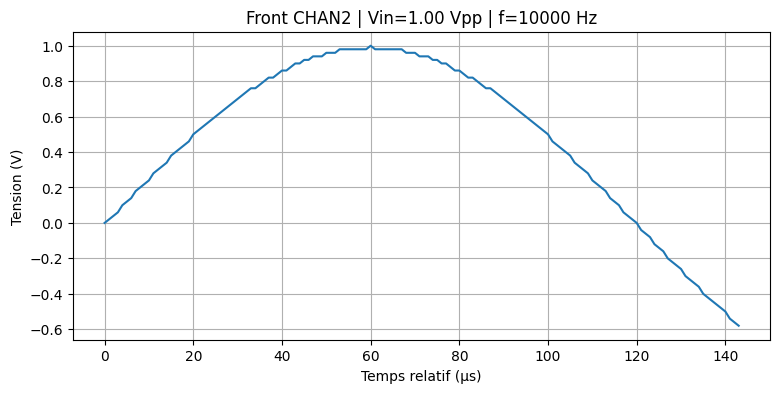

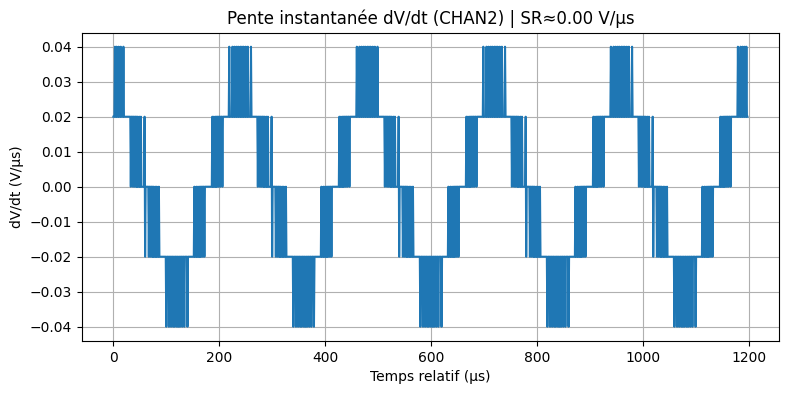

Slew Rate mesuré (max|dV/dt|) ≈ 0.040 V/µs


{'SR_V_per_us': 0.0400000000000034, 'Vin_Vpp': 1.0, 'freq_hz': 10000.0}

In [16]:
# ============================================================
# MEASURE 4 — SLEW RATE (TRÈS IMPORTANT)
# Objectif:
#   1) Forcer un front (carré en entrée)
#   2) Capturer la sortie (CHAN2) en waveform
#   3) Calculer SR = max(|dV/dt|) en V/us
#   4) Afficher: front + dV/dt (et SR)
#
# Hypothèses: CH1 = input, CH2 = output
# Dépend de: ch1_square(), read_waveform(), _swrite()
# ============================================================

import time
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# 1) Utilitaires
# ------------------------------------------------------------
def _dvdt_v_per_us(t, v):
    dv = np.diff(v)
    dt = np.diff(t)
    good = dt > 0
    if not np.any(good):
        return float("nan"), None, None
    dvdt_vs = dv[good] / dt[good]          # V/s
    dvdt_vus = dvdt_vs / 1e6               # V/us
    sr = float(np.max(np.abs(dvdt_vus)))   # V/us
    return sr, dvdt_vus, t[:-1][good]

def _center_window_on_mid(v, frac=0.12, min_pts=120):
    """Fenêtre autour du point le plus proche de la moyenne (front)."""
    n = len(v)
    if n == 0:
        return 0, 0, 0
    vm = float(np.mean(v))
    idx = int(np.argmin(np.abs(v - vm)))
    w = max(min_pts, int(frac * n))
    i0 = max(0, idx - w)
    i1 = min(n, idx + w)
    return idx, i0, i1

def _plot_front_and_dvdt(t, v, title_front, title_dvdt):
    idx, i0, i1 = _center_window_on_mid(v, frac=0.12, min_pts=120)
    t0 = t[idx]

    # Front
    plt.figure(figsize=(9,4))
    plt.plot((t[i0:i1] - t0) * 1e6, v[i0:i1])
    plt.xlabel("Temps relatif (µs)")
    plt.ylabel("Tension (V)")
    plt.title(title_front)
    plt.grid(True)
    plt.show()

    # dV/dt
    sr, dvdt_vus, t_dvdt = _dvdt_v_per_us(t, v)
    if dvdt_vus is None:
        print("⚠ dV/dt invalide (dt<=0 ou trace vide)")
        return sr

    # on centre aussi le graphe dV/dt autour du même temps
    # t_dvdt est proche de t (mais un peu plus court)
    plt.figure(figsize=(9,4))
    plt.plot((t_dvdt - t0) * 1e6, dvdt_vus)
    plt.xlabel("Temps relatif (µs)")
    plt.ylabel("dV/dt (V/µs)")
    plt.title(title_dvdt)
    plt.grid(True)
    plt.show()

    return sr

# ------------------------------------------------------------
# 2) Setup oscillo (zoom front + trigger sortie)
# ------------------------------------------------------------
def _scope_setup_for_front(time_scale_s=5e-6, trig_level_v=0.0):
    # zoom temps
    try:
        _swrite(f":TIM:SCAL {time_scale_s}")
    except Exception:
        pass

    # trigger stable sur CH2
    try:
        _swrite(":TRIG:MODE EDGE")
        _swrite(":TRIG:EDG:SOUR CHAN2")
        _swrite(f":TRIG:EDG:LEV {trig_level_v}")
        _swrite(":RUN")
    except Exception:
        pass

    time.sleep(0.2)

# ------------------------------------------------------------
# 3) Mesure Slew Rate (une seule amplitude)
# ------------------------------------------------------------
def MEASURE_4_SLEW_RATE(
    freq_hz=10000.0,
    vin_vpp=1.0,
    offset_v=0.0,
    time_scale_s=5e-6,
    settle_s=0.30,
    channel_out="CHAN2",
):
    """
    Conseils:
      - freq ~ 10 kHz (front visible, pas trop rapide)
      - vin_vpp: commence petit (0.5 Vpp / 1 Vpp), augmente si besoin
      - time_scale_s: 5 us/div est un bon départ pour LM741
    """
    print("\n=== MEASURE_4_SLEW_RATE ===")
    print(f"Carré CH1: f={freq_hz} Hz | Vin={vin_vpp} Vpp | offset={offset_v} V")
    print(f"Oscillo: time_scale={time_scale_s} s/div | Trigger CH2")

    # Signal carré entrée
    ch1_square(float(freq_hz), float(vin_vpp), float(offset_v), 0.0)
    time.sleep(settle_s)

    # Setup oscillo front
    if not OFFLINE:
        _scope_setup_for_front(time_scale_s=time_scale_s, trig_level_v=0.0)

    # Capture waveform sortie
    t, v = read_waveform(channel_out)

    # Calcul SR + plots
    sr = _plot_front_and_dvdt(
        t, v,
        title_front=f"Front {channel_out} | Vin={vin_vpp:.2f} Vpp | f={freq_hz:.0f} Hz",
        title_dvdt=f"Pente instantanée dV/dt ({channel_out}) | SR≈{sr if 'sr' in locals() else 0:.2f} V/µs"
    )

    # sr affiché proprement (la ligne au-dessus a besoin de sr, donc on refait le titre après)
    print(f"Slew Rate mesuré (max|dV/dt|) ≈ {sr:.3f} V/µs")
    return {"SR_V_per_us": sr, "Vin_Vpp": float(vin_vpp), "freq_hz": float(freq_hz)}


# ----------------------------
# Exemple d’appel (à décommenter)
# ----------------------------
res_sr = MEASURE_4_SLEW_RATE(freq_hz=10000, vin_vpp=1.0, offset_v=0.0)
res_sr


# MEASURE_4_SLEW_RATE_AUTO()

In [17]:
# ============================================================
# MEASURE 4B — SLEW RATE AUTO (anti-saturation + choix amplitude)
# Objectif:
#   - Essayer plusieurs Vin (Vpp) en carré
#   - Rejeter les cas saturés/clippés (sortie CH2)
#   - Garder le meilleur SR mesuré sans clipping
#
# Dépend de: ch1_square(), read_waveform(), _swrite()
# ============================================================

import time
import numpy as np
import matplotlib.pyplot as plt

# ---------- clipping / saturation ----------
def _is_clipped(v, margin=0.02, frac=0.08):
    vmin = float(np.min(v))
    vmax = float(np.max(v))
    vpp = vmax - vmin
    if vpp <= 1e-9:
        return True
    eps = margin * vpp
    near_min = float(np.mean(v <= (vmin + eps)))
    near_max = float(np.mean(v >= (vmax - eps)))
    return (near_min > frac) or (near_max > frac)

# ---------- SR calc ----------
def _slew_rate_vus(t, v):
    dv = np.diff(v)
    dt = np.diff(t)
    good = dt > 0
    if not np.any(good):
        return float("nan")
    dvdt_vus = (dv[good] / dt[good]) / 1e6
    return float(np.max(np.abs(dvdt_vus)))

def _scope_setup_front(time_scale_s=5e-6, trig_level_v=0.0):
    try:
        _swrite(f":TIM:SCAL {time_scale_s}")
        _swrite(":TRIG:MODE EDGE")
        _swrite(":TRIG:EDG:SOUR CHAN2")
        _swrite(f":TRIG:EDG:LEV {trig_level_v}")
        _swrite(":RUN")
    except Exception:
        pass
    time.sleep(0.2)

def _plot_front(t, v, title):
    vm = float(np.mean(v))
    idx = int(np.argmin(np.abs(v - vm)))
    n = len(v)
    w = max(120, n // 10)
    i0 = max(0, idx - w)
    i1 = min(n, idx + w)
    t0 = t[idx]

    plt.figure(figsize=(9,4))
    plt.plot((t[i0:i1] - t0) * 1e6, v[i0:i1])
    plt.xlabel("Temps relatif (µs)")
    plt.ylabel("Tension (V)")
    plt.title(title)
    plt.grid(True)
    plt.show()

def MEASURE_4_SLEW_RATE_AUTO(
    freq_hz=10000.0,
    vin_vpps=(0.2, 0.5, 1.0, 2.0, 3.0),
    offset_v=0.0,
    time_scale_s=5e-6,
    settle_s=0.25,
    channel_out="CHAN2",
    clip_margin=0.02,
    clip_frac=0.08,
):
    print("\n=== MEASURE_4_SLEW_RATE_AUTO ===")
    print(f"Signal: carré {freq_hz:.0f} Hz | essais Vin Vpp = {list(vin_vpps)} | offset={offset_v:.3f} V")
    print(f"{'Vin_cmd(Vpp)':>12} | {'SR(V/us)':>8} | {'clipped':>7} | {'Vmin':>8} | {'Vmax':>8} | {'Vpp':>8}")
    print("-"*68)

    if not OFFLINE:
        _scope_setup_front(time_scale_s=time_scale_s, trig_level_v=0.0)

    best = None  # dict
    all_rows = []

    for vin in vin_vpps:
        # 1) Générateur
        ch1_square(float(freq_hz), float(vin), float(offset_v), 0.0)
        time.sleep(settle_s)

        # 2) Capture sortie
        t, v = read_waveform(channel_out)

        # 3) Mesures
        sr = _slew_rate_vus(t, v)
        clipped = _is_clipped(v, margin=clip_margin, frac=clip_frac)

        vmin = float(np.min(v))
        vmax = float(np.max(v))
        vpp  = vmax - vmin

        row = {
            "vin_cmd_vpp": float(vin),
            "sr_vus": float(sr),
            "clipped": bool(clipped),
            "vmin": vmin,
            "vmax": vmax,
            "vpp": float(vpp),
            "t": t,
            "v": v,
        }
        all_rows.append(row)

        print(f"{vin:12.3f} | {sr:8.3f} | {str(clipped):>7} | {vmin:8.3f} | {vmax:8.3f} | {vpp:8.3f}")

        # 4) Sélection du "best" : max SR sans clipping
        if (not clipped) and (not np.isnan(sr)):
            if best is None or sr > best["sr_vus"]:
                best = row

    if best is None:
        print("\n⚠ Aucun point non-clippé trouvé.")
        print("   -> baisse Vin, baisse le gain du montage, vérifie alim ±V, sonde x10/x1, et l’échelle verticale.")
        return None

    print("\n✅ BEST (SR max sans clipping) :")
    print(f"   Vin_cmd = {best['vin_cmd_vpp']:.3f} Vpp")
    print(f"   Slew Rate ≈ {best['sr_vus']:.3f} V/µs")
    print(f"   Vout ≈ [{best['vmin']:.3f} ; {best['vmax']:.3f}] V  (Vpp={best['vpp']:.3f})")

    _plot_front(best["t"], best["v"], title=f"Front {channel_out} | Vin={best['vin_cmd_vpp']:.2f} Vpp | SR≈{best['sr_vus']:.2f} V/µs")

    return {
        "SR_V_per_us": best["sr_vus"],
        "Vin_Vpp": best["vin_cmd_vpp"],
        "freq_hz": float(freq_hz),
        "best_row": best,
        "all_rows": all_rows,
    }


# ----------------------------
# Exemple d’appel (à décommenter)
# ----------------------------
res_sr_auto = MEASURE_4_SLEW_RATE_AUTO(freq_hz=10000, vin_vpps=(0.2,0.5,1,2,3))
res_sr_auto



=== MEASURE_4_SLEW_RATE_AUTO ===
Signal: carré 10000 Hz | essais Vin Vpp = [0.2, 0.5, 1, 2, 3] | offset=0.000 V
Vin_cmd(Vpp) | SR(V/us) | clipped |     Vmin |     Vmax |      Vpp
--------------------------------------------------------------------
[GEN WRITE] VOLT:UNIT VPP
[GEN WRITE] APPL:SQU 10000.0,0.2,0.0
[GEN WRITE] PHAS 0.0
[GEN WRITE] OUTP ON
CH1: ON
[SCOPE WRITE] :WAV:SOUR CHAN2
[SCOPE WRITE] :WAV:MODE NORM
[SCOPE WRITE] :WAV:FORM BYTE
[SCOPE QUERY] :WAV:PRE?
[SCOPE WRITE] :WAV:DATA?
       0.200 |    0.040 |    True |   -1.000 |    1.000 |    2.000
[GEN WRITE] VOLT:UNIT VPP
[GEN WRITE] APPL:SQU 10000.0,0.5,0.0
[GEN WRITE] PHAS 0.0
[GEN WRITE] OUTP ON
CH1: ON
[SCOPE WRITE] :WAV:SOUR CHAN2
[SCOPE WRITE] :WAV:MODE NORM
[SCOPE WRITE] :WAV:FORM BYTE
[SCOPE QUERY] :WAV:PRE?
[SCOPE WRITE] :WAV:DATA?
       0.500 |    0.040 |    True |   -1.000 |    1.000 |    2.000
[GEN WRITE] VOLT:UNIT VPP
[GEN WRITE] APPL:SQU 10000.0,1.0,0.0
[GEN WRITE] PHAS 0.0
[GEN WRITE] OUTP ON
CH1: ON
[SCOPE 

# MEASURE_5_TRANSIENT() (rise time / overshoot)


=== MEASURE_5_TRANSIENT (Rise time / Overshoot) ===
Carré CH1: f=10000 Hz | Vin=1.000 Vpp | offset=0.000 V
Scope: time_scale=5e-06 s/div | mode=WAVEFORM
[GEN WRITE] VOLT:UNIT VPP
[GEN WRITE] APPL:SQU 10000.0,1.0,0.0
[GEN WRITE] PHAS 0.0
[GEN WRITE] OUTP ON
CH1: ON
[SCOPE WRITE] :WAV:SOUR CHAN2
[SCOPE WRITE] :WAV:MODE NORM
[SCOPE WRITE] :WAV:FORM BYTE
[SCOPE QUERY] :WAV:PRE?
[SCOPE WRITE] :WAV:DATA?
Vlow ≈ -0.960 V | Vhigh ≈ 0.940 V
RiseTime(10-90%) ≈ 65.00 µs
Overshoot ≈ 3.16 %


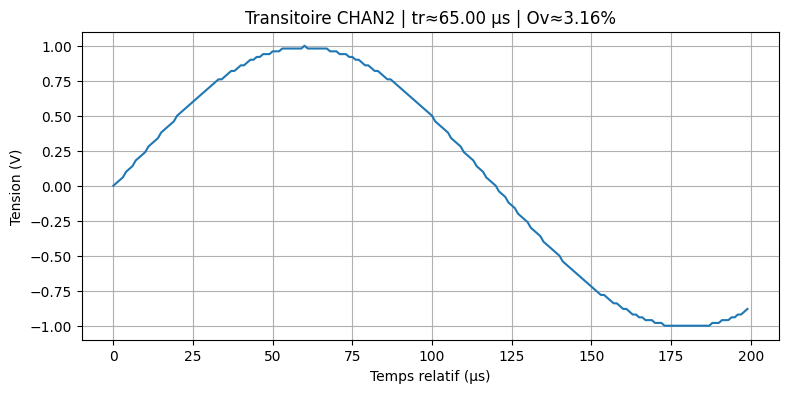

{'rise_time_s': 6.499999999999998e-05,
 'overshoot_pct': 3.1578947368421026,
 'vlow': -0.96,
 'vhigh': 0.9400000000000001,
 'mode': 'WAVEFORM'}

In [18]:
# ============================================================
# MEASURE 5 — RÉPONSE TRANSITOIRE (Rise time + Overshoot)
# Objectif:
#   - Envoyer un carré (step)
#   - Mesurer rise time (10%->90%) + overshoot (%) sur CH2
#
# 2 modes:
#   A) "MEAS" (le plus simple si supporté par ton Rigol)
#   B) "WAVEFORM" (robuste: calcul à partir des points)
#
# Dépend de: ch1_square(), read_waveform(), compute_metrics(), _swrite(), meas()
# ============================================================

import time
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# A) Mode MEAS (si ton scope répond à :MEAS:ITEM? RTIM / OVER)
# ------------------------------------------------------------
def _try_scope_meas_rise_overshoot(ch_out=2):
    """
    Essaie des commandes MEAS classiques.
    Selon firmware, OVSH/OVER peut varier.
    """
    rise = float("nan")
    over = float("nan")

    # Rise time
    for key in ["RTIM", "RTIMe", "RISE", "RIS"]:
        try:
            rise = float(meas(key, ch_out))
            if not np.isnan(rise) and rise > 0:
                break
        except Exception:
            pass

    # Overshoot (selon modèles: OVSH, OVER, POVS... -> on tente)
    for key in ["OVSH", "OVER", "POVS", "Povershoot"]:
        try:
            over = float(meas(key, ch_out))
            if not np.isnan(over):
                break
        except Exception:
            pass

    return rise, over


# ------------------------------------------------------------
# B) Mode WAVEFORM: calcul 10%->90% + overshoot
# ------------------------------------------------------------
def _rise_time_10_90(t, v):
    """
    Calcule tr(10->90%) sur un front montant.
    Méthode:
      - On estime Vlow et Vhigh via percentiles
      - Seuils 10% et 90%
      - On cherche le premier passage croissant
    Retour: (tr_s, t10, t90, Vlow, Vhigh)
    """
    if len(v) < 10:
        return float("nan"), None, None, None, None

    # Estimations robustes des niveaux bas/haut
    vlow  = float(np.percentile(v, 10))
    vhigh = float(np.percentile(v, 90))
    if vhigh <= vlow:
        return float("nan"), None, None, vlow, vhigh

    v10 = vlow + 0.10 * (vhigh - vlow)
    v90 = vlow + 0.90 * (vhigh - vlow)

    # Chercher un front montant: on prend zone autour du milieu
    vm = float(0.5*(vlow+vhigh))
    idx_mid = int(np.argmin(np.abs(v - vm)))

    # On scanne localement pour trouver t10 et t90 dans le bon ordre
    # window = ±25% de la trace
    n = len(v)
    w = max(50, n//4)
    i0 = max(0, idx_mid - w)
    i1 = min(n, idx_mid + w)

    vv = v[i0:i1]
    tt = t[i0:i1]

    # index passage 10%
    i10 = None
    for i in range(1, len(vv)):
        if vv[i-1] < v10 <= vv[i]:
            i10 = i
            break

    if i10 is None:
        return float("nan"), None, None, vlow, vhigh

    # index passage 90% après i10
    i90 = None
    for i in range(i10+1, len(vv)):
        if vv[i-1] < v90 <= vv[i]:
            i90 = i
            break

    if i90 is None:
        return float("nan"), None, None, vlow, vhigh

    t10 = float(tt[i10])
    t90 = float(tt[i90])
    tr = t90 - t10
    return float(tr), t10, t90, vlow, vhigh


def _overshoot_percent(v, vlow, vhigh):
    """
    Overshoot (%) = (Vpeak - Vhigh) / (Vhigh - Vlow) * 100
    """
    if vhigh <= vlow:
        return float("nan")
    vpeak = float(np.max(v))
    return float((vpeak - vhigh) / (vhigh - vlow) * 100.0)


def _plot_transient(t, v, title):
    # centre autour du milieu
    vm = float(np.mean(v))
    idx = int(np.argmin(np.abs(v - vm)))
    n = len(v)
    w = max(200, n//8)
    i0 = max(0, idx - w)
    i1 = min(n, idx + w)
    t0 = t[idx]

    plt.figure(figsize=(9,4))
    plt.plot((t[i0:i1] - t0) * 1e6, v[i0:i1])
    plt.xlabel("Temps relatif (µs)")
    plt.ylabel("Tension (V)")
    plt.title(title)
    plt.grid(True)
    plt.show()


# ------------------------------------------------------------
# MEASURE 5 — main
# ------------------------------------------------------------
def MEASURE_5_TRANSIENT(
    freq_hz=10000.0,
    vin_vpp=1.0,
    offset_v=0.0,
    time_scale_s=5e-6,
    settle_s=0.30,
    channel_out="CHAN2",
    mode="WAVEFORM",   # "MEAS" ou "WAVEFORM"
):
    """
    Conseil:
      - Pour rise time: carrés pas trop rapides (5k-20k) + zoom temps (us/div)
      - Trigger CH2 pour stabiliser la capture
    """
    print("\n=== MEASURE_5_TRANSIENT (Rise time / Overshoot) ===")
    print(f"Carré CH1: f={freq_hz:.0f} Hz | Vin={vin_vpp:.3f} Vpp | offset={offset_v:.3f} V")
    print(f"Scope: time_scale={time_scale_s} s/div | mode={mode}")

    # Générateur
    ch1_square(float(freq_hz), float(vin_vpp), float(offset_v), 0.0)
    time.sleep(settle_s)

    # Setup scope (front + trigger)
    if not OFFLINE:
        try:
            _swrite(f":TIM:SCAL {time_scale_s}")
            _swrite(":TRIG:MODE EDGE")
            _swrite(":TRIG:EDG:SOUR CHAN2")
            _swrite(":TRIG:EDG:LEV 0")
            _swrite(":RUN")
        except Exception:
            pass
        time.sleep(0.2)

    # Mode MEAS (si supporté)
    if mode.upper() == "MEAS":
        rise_s, over_pct = _try_scope_meas_rise_overshoot(ch_out=2)

        print(f"RiseTime (scope) = {rise_s*1e6:.2f} µs" if not np.isnan(rise_s) else "RiseTime (scope) = NaN (non supporté)")
        print(f"Overshoot (scope) = {over_pct:.2f} %" if not np.isnan(over_pct) else "Overshoot (scope) = NaN (non supporté)")

        return {"rise_time_s": float(rise_s), "overshoot_pct": float(over_pct), "mode": "MEAS"}

    # Mode WAVEFORM (robuste)
    t, v = read_waveform(channel_out)

    tr_s, t10, t90, vlow, vhigh = _rise_time_10_90(t, v)
    ov_pct = _overshoot_percent(v, vlow, vhigh) if (vlow is not None and vhigh is not None) else float("nan")

    print(f"Vlow ≈ {vlow:.3f} V | Vhigh ≈ {vhigh:.3f} V")
    if np.isnan(tr_s):
        print("RiseTime(10-90%) = NaN (front non détecté / mauvais zoom)")
    else:
        print(f"RiseTime(10-90%) ≈ {tr_s*1e6:.2f} µs")
    if np.isnan(ov_pct):
        print("Overshoot = NaN")
    else:
        print(f"Overshoot ≈ {ov_pct:.2f} %")

    _plot_transient(t, v, title=f"Transitoire {channel_out} | tr≈{(tr_s*1e6 if not np.isnan(tr_s) else np.nan):.2f} µs | Ov≈{(ov_pct if not np.isnan(ov_pct) else np.nan):.2f}%")

    return {
        "rise_time_s": float(tr_s),
        "overshoot_pct": float(ov_pct),
        "vlow": float(vlow) if vlow is not None else float("nan"),
        "vhigh": float(vhigh) if vhigh is not None else float("nan"),
        "mode": "WAVEFORM",
    }


# ----------------------------
# Exemple d’appel (à décommenter)
# ----------------------------
res_tr = MEASURE_5_TRANSIENT(freq_hz=10000, vin_vpp=1.0, time_scale_s=5e-6, mode="WAVEFORM")
res_tr


# MEASURE_6_OFFSET_OUTPUT()

In [19]:
# ============================================================
# MEASURE 6 — OFFSET EN SORTIE (Vout offset)
# Objectif:
#   - Mesurer la tension moyenne en sortie quand l’entrée est ~0 V
#   - Deux façons:
#       A) Entrée en DC offset 0 (sinus amplitude très petite)
#       B) Entrée en "DC" si tu veux (selon générateur / montage)
#
# Hypothèses: CH1 = input, CH2 = output
# Dépend de: ch1_sine(), read_waveform(), compute_metrics(), meas(), _swrite()
# ============================================================

import time
import numpy as np

def MEASURE_6_OFFSET_OUTPUT(
    freq_hz=1000.0,
    vin_vpp=0.02,          # très petit (20 mVpp) pour ~0V en entrée
    vin_offset_v=0.0,      # offset DC demandé au générateur (souvent 0)
    settle_s=0.30,
    method="WAVEFORM",     # "MEAS" ou "WAVEFORM"
    set_timebase=True,
):
    """
    Reco exam:
      - Vin_vpp très petit (10-50 mVpp) pour approx entrée = 0
      - Mesure Vmean (CH2) = offset de sortie
      - Si bruit/instable: augmenter settle_s et/ou mettre AVG sur scope (manuel)
    """
    print("\n=== MEASURE_6_OFFSET_OUTPUT ===")
    print(f"Entrée ~0: SIN f={freq_hz:.0f} Hz | Vin={vin_vpp:.3f} Vpp | Vin_offset={vin_offset_v:.3f} V")

    # 1) Générateur: sinus très faible
    ch1_sine(float(freq_hz), float(vin_vpp), float(vin_offset_v), 0.0)
    time.sleep(settle_s)

    # 2) Timebase optionnelle
    if set_timebase and not OFFLINE:
        T = 1.0 / float(freq_hz)
        try:
            _swrite(f":TIM:SCAL {T/4.0}")
            time.sleep(0.15)
        except Exception:
            pass

    # 3) Mesure offset entrée/sortie
    if method.upper() == "MEAS":
        vin_mean  = float(meas("VAVG", 1))   # ou "VMEAN" selon firmware
        vout_mean = float(meas("VAVG", 2))
        print(f"Vin_mean  (scope MEAS) = {vin_mean:.6f} V")
        print(f"Vout_mean (scope MEAS) = {vout_mean:.6f} V")
        return {
            "vin_mean_v": vin_mean,
            "vout_mean_v": vout_mean,
            "method": "MEAS",
        }

    # 4) Méthode waveform (robuste)
    t1, v1 = read_waveform("CHAN1")
    t2, v2 = read_waveform("CHAN2")

    m1 = compute_metrics(t1, v1)
    m2 = compute_metrics(t2, v2)

    vin_mean  = float(m1["Vmean"])
    vout_mean = float(m2["Vmean"])

    print(f"Vin_mean  (waveform) = {vin_mean:.6f} V")
    print(f"Vout_mean (waveform) = {vout_mean:.6f} V")
    print("=> Offset de sortie ≈ Vout_mean (si Vin_mean ≈ 0)")

    # petite sanity check
    if abs(vin_mean) > 0.02:
        print("⚠ Vin_mean pas proche de 0V -> baisse Vin_vpp ou vérifie offset/sonde/couplage DC.")

    return {
        "vin_mean_v": vin_mean,
        "vout_mean_v": vout_mean,
        "vin_vpp_meas": float(m1["Vpp"]),
        "vout_vpp_meas": float(m2["Vpp"]),
        "method": "WAVEFORM",
    }


# ----------------------------
# Exemple d’appel (à décommenter)
# ----------------------------
res_off = MEASURE_6_OFFSET_OUTPUT(freq_hz=1000, vin_vpp=0.02, vin_offset_v=0.0, method="WAVEFORM")
res_off



=== MEASURE_6_OFFSET_OUTPUT ===
Entrée ~0: SIN f=1000 Hz | Vin=0.020 Vpp | Vin_offset=0.000 V
[GEN WRITE] VOLT:UNIT VPP
[GEN WRITE] APPL:SIN 1000.0,0.02,0.0
[GEN WRITE] PHAS 0.0
[GEN WRITE] OUTP ON
CH1: ON
[SCOPE WRITE] :WAV:SOUR CHAN1
[SCOPE WRITE] :WAV:MODE NORM
[SCOPE WRITE] :WAV:FORM BYTE
[SCOPE QUERY] :WAV:PRE?
[SCOPE WRITE] :WAV:DATA?
[SCOPE WRITE] :WAV:SOUR CHAN2
[SCOPE WRITE] :WAV:MODE NORM
[SCOPE WRITE] :WAV:FORM BYTE
[SCOPE QUERY] :WAV:PRE?
[SCOPE WRITE] :WAV:DATA?
Vin_mean  (waveform) = -0.009867 V
Vout_mean (waveform) = -0.009867 V
=> Offset de sortie ≈ Vout_mean (si Vin_mean ≈ 0)


{'vin_mean_v': -0.009866666666666682,
 'vout_mean_v': -0.009866666666666682,
 'vin_vpp_meas': 2.0,
 'vout_vpp_meas': 2.0,
 'method': 'WAVEFORM'}

# MEASURE_7_OUTPUT_CURRENT_BONUS()


=== MEASURE_7_OUTPUT_CURRENT_BONUS ===
Charge RL = 1000.0 Ω (physique)
Signal: SIN f=1000.0 Hz | Vin=1.000 Vpp | offset=0.000 V
[GEN WRITE] VOLT:UNIT VPP
[GEN WRITE] APPL:SIN 1000.0,1.0,0.0
[GEN WRITE] PHAS 0.0
[GEN WRITE] OUTP ON
CH1: ON
[SCOPE WRITE] :WAV:SOUR CHAN2
[SCOPE WRITE] :WAV:MODE NORM
[SCOPE WRITE] :WAV:FORM BYTE
[SCOPE QUERY] :WAV:PRE?
[SCOPE WRITE] :WAV:DATA?

--- Vout (CH2) ---
Vmin  = -1.0000 V
Vmax  = 1.0000 V
Vpp   = 2.0000 V
Vmean = -0.009867 V
Vrms  = 0.7068 V

--- Iout déduit (Vout/RL) ---
Irms  = 0.707 mA
Ipeak = 1.000 mA
Ipp   = 2.000 mA


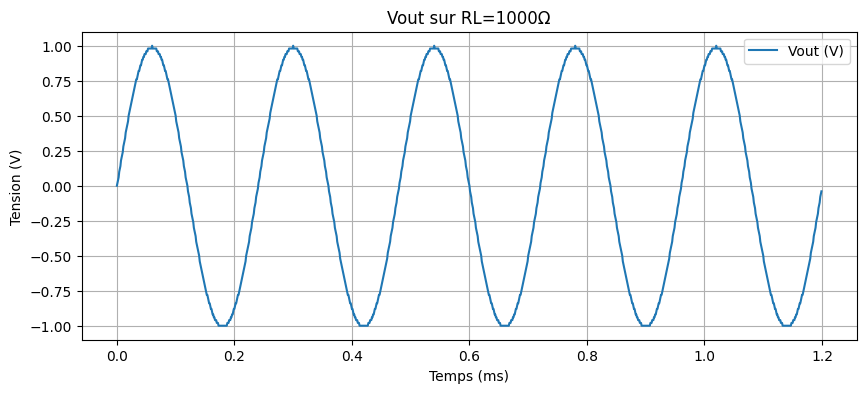

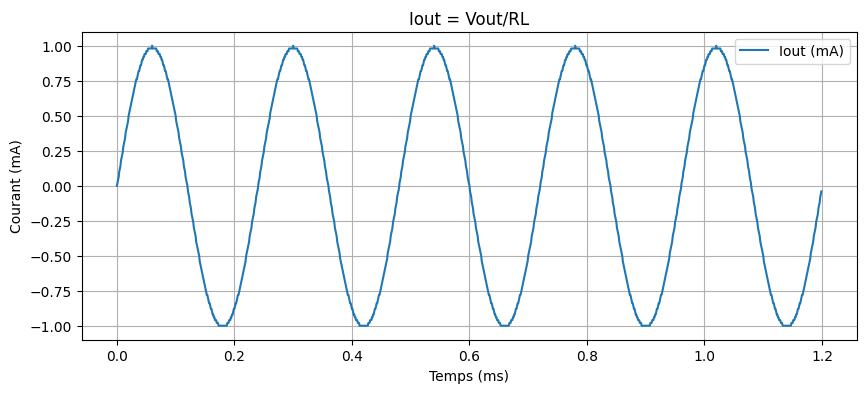

{'RL_ohms': 1000.0,
 'wave': 'SIN',
 'freq_hz': 1000.0,
 'vin_vpp_cmd': 1.0,
 'Vout_metrics': {'Vmin': -1.0,
  'Vmax': 1.0,
  'Vpp': 2.0,
  'Vmean': -0.009866666666666682,
  'Vrms': 0.7068007734385505,
  'Freq_est_zc': 4166.666666666667,
  'Freq_est_fft': nan,
  'Freq_est': 4166.666666666667},
 'Irms_A': 0.0007068007734385506,
 'Ipeak_A': 0.001,
 'Ipp_A': 0.002}

In [20]:
# ============================================================
# MEASURE 7 — COURANT DE SORTIE (BONUS)
# IMPORTANT:
#   - Un oscilloscope seul ne mesure pas directement le courant.
#   - On le déduit via une résistance de charge RL en sortie:
#         Iout(t) = Vout(t) / RL
#   - Donc il faut physiquement mettre RL (ex: 1kΩ, 470Ω, 220Ω ...)
#     entre la sortie et la masse (ou sortie->masse).
#
# Objectif:
#   - Envoyer un sinus (ou carré) et mesurer:
#         Iout_rms, Iout_peak, Iout_pp
#   - Détecter si ça clip/sature quand RL est trop faible.
#
# Hypothèses: CH2 = Vout sur RL (tension de sortie)
# Dépend de: ch1_sine(), ch1_square(), read_waveform(), compute_metrics(), _swrite()
# ============================================================

import time
import numpy as np
import matplotlib.pyplot as plt

def MEASURE_7_OUTPUT_CURRENT_BONUS(
    RL_ohms: float = 1000.0,       # résistance de charge en ohms (physique)
    wave: str = "SIN",             # "SIN" ou "SQU"
    freq_hz: float = 1000.0,
    vin_vpp: float = 1.0,
    vin_offset_v: float = 0.0,
    settle_s: float = 0.25,
    channel_out: str = "CHAN2",
    set_timebase: bool = True,
    plot: bool = True,
):
    """
    Mesures sorties:
      - Vout metrics
      - Iout(t) = Vout(t)/RL
      - Irms, Ipeak, Ipp
    """
    RL_ohms = float(RL_ohms)
    if RL_ohms <= 0:
        raise ValueError("RL_ohms doit être > 0")

    wave = wave.upper().strip()
    print("\n=== MEASURE_7_OUTPUT_CURRENT_BONUS ===")
    print(f"Charge RL = {RL_ohms:.1f} Ω (physique)")
    print(f"Signal: {wave} f={freq_hz:.1f} Hz | Vin={vin_vpp:.3f} Vpp | offset={vin_offset_v:.3f} V")

    # 1) Générateur
    if wave == "SIN":
        ch1_sine(float(freq_hz), float(vin_vpp), float(vin_offset_v), 0.0)
    elif wave in ("SQU", "SQUARE"):
        ch1_square(float(freq_hz), float(vin_vpp), float(vin_offset_v), 0.0)
    else:
        raise ValueError("wave doit être 'SIN' ou 'SQU'")

    time.sleep(settle_s)

    # 2) Timebase optionnelle
    if set_timebase and not OFFLINE:
        T = 1.0 / float(freq_hz)
        try:
            _swrite(f":TIM:SCAL {T/4.0}")
            time.sleep(0.12)
        except Exception:
            pass

    # 3) Capture Vout
    t, vout = read_waveform(channel_out)
    mV = compute_metrics(t, vout)

    # 4) Calcul courant
    iout = vout / RL_ohms  # A
    Irms = float(np.sqrt(np.mean(iout**2)))
    Ipeak = float(np.max(np.abs(iout)))
    Ipp = float(np.max(iout) - np.min(iout))

    # 5) Affichage
    print("\n--- Vout (CH2) ---")
    print(f"Vmin  = {mV['Vmin']:.4f} V")
    print(f"Vmax  = {mV['Vmax']:.4f} V")
    print(f"Vpp   = {mV['Vpp']:.4f} V")
    print(f"Vmean = {mV['Vmean']:.6f} V")
    print(f"Vrms  = {mV['Vrms']:.4f} V")

    print("\n--- Iout déduit (Vout/RL) ---")
    print(f"Irms  = {Irms*1e3:.3f} mA")
    print(f"Ipeak = {Ipeak*1e3:.3f} mA")
    print(f"Ipp   = {Ipp*1e3:.3f} mA")

    # 6) Plot optionnel
    if plot:
        plt.figure(figsize=(10,4))
        plt.plot(t*1e3, vout, label="Vout (V)")
        plt.xlabel("Temps (ms)")
        plt.ylabel("Tension (V)")
        plt.title(f"Vout sur RL={RL_ohms:.0f}Ω")
        plt.grid(True)
        plt.legend()
        plt.show()

        plt.figure(figsize=(10,4))
        plt.plot(t*1e3, iout*1e3, label="Iout (mA)")
        plt.xlabel("Temps (ms)")
        plt.ylabel("Courant (mA)")
        plt.title("Iout = Vout/RL")
        plt.grid(True)
        plt.legend()
        plt.show()

    return {
        "RL_ohms": RL_ohms,
        "wave": wave,
        "freq_hz": float(freq_hz),
        "vin_vpp_cmd": float(vin_vpp),
        "Vout_metrics": mV,
        "Irms_A": Irms,
        "Ipeak_A": Ipeak,
        "Ipp_A": Ipp,
    }


# ----------------------------
# Exemple d’appel (à décommenter)
# ----------------------------
res_i = MEASURE_7_OUTPUT_CURRENT_BONUS(RL_ohms=1000, wave="SIN", freq_hz=1000, vin_vpp=1.0)
res_i
